In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from acor import acor
from astropy.cosmology import Planck15
import astropy.cosmology as cosmo
import astropy.units as u
import corner
import h5py
from matplotlib.colors import LogNorm
from multiprocessing import Pool
import pandas
import pystan
import scipy.integrate as si
from scipy.interpolate import interp1d, interp2d
import scipy.stats as ss
import seaborn as sns
import sys
from tqdm import tnrange, tqdm_notebook
import warnings

p = '/Users/wfarr/Research/CBCPopulation/O2Populations/code'
try:
    sys.path.index(p)
except ValueError:
    sys.path.append(p)
    
import vt

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Some plotting settings for the paper figures:

In [3]:
fs = 433.62/72.0
figsize_pub=(fs, fs)

Our population is going to have $5 \, M_\odot \leq m \leq 40 \, M_\odot$, and we can guarantee that there will be no systems detected with $z > 1.6$:

In [4]:
vt.fraction_above_threshold(40, 40, 1.6, 8, psd_fn=vt.ls.SimNoisePSDaLIGODesignSensitivityP1200087)

0.0

Let's store the thetas from vt:

In [110]:
with h5py.File('thetas.h5', 'w') as out:
    out.create_dataset('Theta', data=vt.thetas, compression='gzip', shuffle=True)

Let's draw a synthetic population of sources.

In [5]:
def mc_eta_from_m1_m2(m1, m2):
    mt = m1+m2
    eta = m1*m2/(mt*mt)
    
    mc = mt*eta**(3.0/5.0)
    
    return (mc, eta)

188676 mergers per year out to redshift 1.60


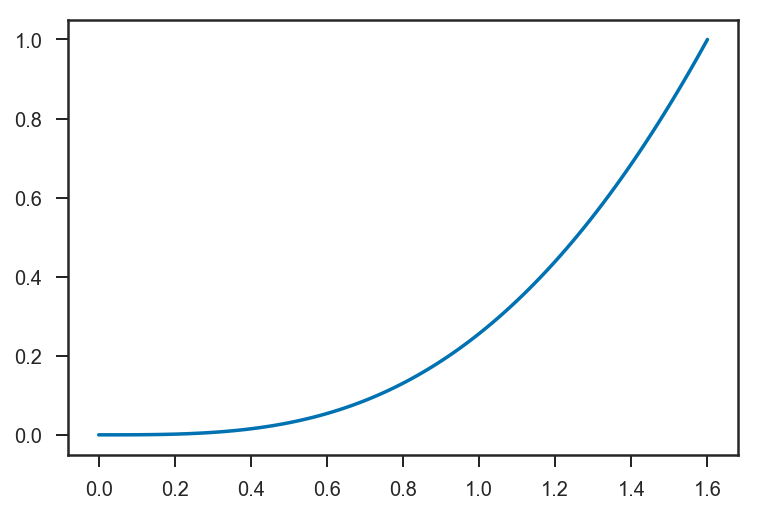

In [6]:
zs = linspace(0, 1.6, 100)
dNdz = 4.0*pi*100.0*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value*(1+zs)**2
N = trapz(dNdz, zs)

print('{:g} mergers per year out to redshift {:.2f}'.format(N, np.max(zs)))

dNdz /= trapz(dNdz, zs)

zcum = si.cumtrapz(dNdz, zs, initial=0)
plot(zs, zcum)

zinterp = interp1d(zcum, zs)

We will generate one year of mergers at design sensitivity (out to redshift 1.6, which is the detection horizon for our most massive black holes).  The mass distribution will be
$$
p\left( m_1, m_2 \right) \propto \frac{m_1^{-1.5}}{m_1 - M_\mathrm{min}}
$$
(flat in log $m_1$ and flat in $q$) and the rate will be 
$$
\frac{\mathrm{d} N}{\mathrm{d} V_C \mathrm{d} t} = 100 \, \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1} \left( 1 + z \right)^3
$$
in the comoving frame, or an observed merger density of 
$$
\frac{\mathrm{d} N}{\mathrm{d} z} = 100 \, \mathrm{Gpc}^{-3} \frac{\mathrm{d} V_C}{\mathrm{d} z} \left( 1 + z \right)^2.
$$

Let's talk a bit about the observational model.  We imagine that the true amplitude of the source in our detector (we will use only one detector here---with a hack that gives uncertainty appropriate to multiple detectors) is given by 
$$
A_\mathrm{true} = A_\mathrm{opt}\left( m_1, m_2, d_L \right) \Theta_\mathrm{true},
$$
where $A_\mathrm{opt}$ is the amplitude for a face-on, overhead source with the given parameters, and $\Theta_\mathrm{true}$ is drawn from the isotropic distribution of angular amplitude factors given, e.g., in [Finn & Chernoff (1993)](https://ui.adsabs.harvard.edu/#abs/1993PhRvD..47.2198F/abstract).  We imagine that we measure the amplitude with unit uncertainty:
$$
A_\mathrm{obs} = A_\mathrm{true} + N(0,1),
$$
and we also measure the angular factor
$$
\Theta_\mathrm{obs} = \Theta_\mathrm{true} + N\left(0, \sigma_\Theta\right)
$$
with 
$$
\sigma_\Theta = 0.15 \times \frac{8}{A_\mathrm{true}}.
$$
This value of $\sigma_\Theta$ is chosen to match the uncertainty of a median angular source at threshold to the relative distance uncertainty of GW170814.  Note that the observation of the angular factor is not restricted to the range $[0,1]$.  Only events with $A_\mathrm{obs} > 8$ are considered "detected."

We also observe a chirp mass: 
$$
\log \mathcal{M}_\mathrm{obs} = \log \left( \left( 1+z \right) \mathcal{M}_\mathrm{true}\left( m_1, m_2 \right) \right) + N\left( 0, \sigma_\mathrm{M}\right)
$$
and symmetric mass ratio
$$
\eta_\mathrm{obs} = \eta_\mathrm{true} \left( m_1, m_2 \right) + N\left( 0, \sigma_\eta \right)
$$
with 
$$
\sigma_\mathrm{M} = \sigma_\eta = 0.017 \times \frac{8}{A_\mathrm{true}};
$$
this uncertainty is tuned to match LVT151012.

In [10]:
rstate = random.get_state()
random.seed(752812)

try:
    ngen1 = random.poisson(N)
    ngen4 = random.poisson(4*N) # ngen1 + ngen4 is five years' worth of observations
    N_1yr = -1
    
    duty_cycle = 0.5

    # MMax and alpha numbers come from MAP on Fishbach & Holz (2017)
    MMin = 5
    MMax = 37.5
    alpha = 0.75
    beta = 0.0

    m1s = []
    m2s = []
    zs = []
    dls = []
    thetas = []

    mc_obs = []
    eta_obs = []
    A_obs = []
    theta_obs = []
    
    sigma_mc = []
    sigma_eta = []
    sigma_theta = []
    
    ts = concatenate(([0.0], sort(vt.thetas), [1.0]))
    
    tcum = interp1d(linspace(0, 1, ts.shape[0]), ts)

    for i in tnrange(ngen1+ngen4):
        if i == ngen1:
            # One year of events has elapsed
            N_1yr = len(m1s)
            
        if rand() > duty_cycle:
            continue # Skip it!
            
        m1 = ((MMax**(1-alpha)-MMin**(1-alpha))*rand() + MMin**(1-alpha))**(1.0/(1-alpha))
        m2 = ((m1**(1+beta)-MMin**(1+beta))*rand() + MMin**(1+beta))**(1.0/(1+beta))
        z = zinterp(rand())
        dl = Planck15.luminosity_distance(z).to(u.Gpc).value

        opt_snr = vt.optimal_snr(m1, m2, z, psd_fn=vt.ls.SimNoisePSDaLIGODesignSensitivityP1200087)
        
        th = tcum(rand())
        
        A = th * opt_snr
        
        sa = 1.0
        st = 0.15*8.0/A
        
        Aobs = random.normal(loc=A, scale=sa)

        if Aobs > 8:        
            m1s.append(m1)
            m2s.append(m2)
            zs.append(z)
            dls.append(dl)
            thetas.append(th)
            
            th_obs = th + st*randn()

            mc, eta = mc_eta_from_m1_m2(m1, m2)

            sm = 8/Aobs*0.017
            se = 8/Aobs*0.017

            mco = random.lognormal(mean=log(mc*(1+z)), sigma=sm)
            etao = eta + se*randn() # This can give eta > 0.25 or eta < 0, but truncating causes numerical prob's in Stan, apparently

            mc_obs.append(mco)
            eta_obs.append(etao)
            A_obs.append(Aobs)
            theta_obs.append(th_obs)
            
            sigma_mc.append(sm)
            sigma_eta.append(se)
            sigma_theta.append(st)
finally:
    random.set_state(rstate)
    
with h5py.File('observations.h5', 'w') as out:
    out.attrs['N_1yr'] = N_1yr
    out.attrs['duty_cycle'] = duty_cycle
    
    out.attrs['alpha_true'] = alpha
    out.attrs['beta_true'] = beta
    out.attrs['MMin_true'] = MMin
    out.attrs['MMax_true'] = MMax
    
    tg = out.create_group('truth')
    for n, d in (('m1', m1s), ('m2', m2s), ('z', zs), ('dl', dls), ('theta', thetas)):
        tg.create_dataset(n, data=array(d), compression='gzip', shuffle=True)
    
    og = out.create_group('observations')
    for n, d in (('mc', mc_obs), ('eta', eta_obs), ('A', A_obs), ('theta', theta_obs), ('sigma_mc', sigma_mc), ('sigma_eta', sigma_eta), ('sigma_theta', sigma_theta)):
        og.create_dataset(n, data=array(d), compression='gzip', shuffle=True)

Executing the code below will re-load the generated observations:

In [4]:
with h5py.File('observations.h5', 'r') as inp:
    N_1yr = inp.attrs['N_1yr']
    duty_cycle = inp.attrs['duty_cycle']
    
    alpha = inp.attrs['alpha_true']
    beta = inp.attrs['beta_true']
    MMin = inp.attrs['MMin_true']
    MMax = inp.attrs['MMax_true']
    
    m1s = array(inp['truth']['m1'])
    m2s = array(inp['truth']['m2'])
    zs = array(inp['truth']['z'])
    dls = array(inp['truth']['dl'])
    thetas = array(inp['truth']['theta'])
    
    mc_obs = array(inp['observations']['mc'])
    eta_obs = array(inp['observations']['eta'])
    A_obs = array(inp['observations']['A'])
    theta_obs = array(inp['observations']['theta'])
    sigma_mc = array(inp['observations']['sigma_mc'])
    sigma_eta = array(inp['observations']['sigma_eta'])
    sigma_theta = array(inp['observations']['sigma_theta'])

Can we see the right behaviour in the maximum (or minimum?) mass?  Below is plotted the observed $\mathcal{M}$ versus $\mathcal{M}^{5/6}/A \simeq d_L$ (with errobars) for the hypothetical catalog.  

If we know the exact observed masses and distances to all the events, what can we reconstruct about the Hubble constant?

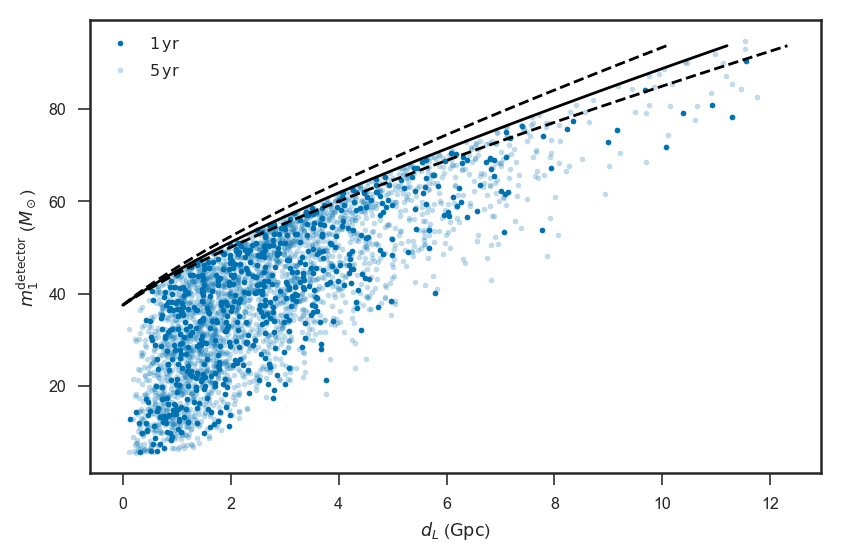

In [22]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):

    plot(dls[:N_1yr], (1+zs[:N_1yr])*m1s[:N_1yr], '.', label=r'$1\,\mathrm{yr}$')
    plot(dls, (1+zs)*m1s, '.', alpha=0.25, color=sns.color_palette()[0], label=r'$5\,\mathrm{yr}$')
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{detector}$ ($M_\odot$)')

    z = linspace(0,1.5,100)
    d = Planck15.luminosity_distance(z).to(u.Gpc).value

    plot(d, (1+z)*MMax, '-k')
    plot(0.9*d, (1+z)*MMax, '--k')
    plot(1.1*d, (1+z)*MMax, '--k')

    legend(loc='best')

    tight_layout()
    savefig('paper/plots/m1-dL-true.pdf')
    
    with h5py.File('paper/plots/m1-dL-true.h5', 'w') as out:
        def cd(g,n,d):
            g.create_dataset(n, data=d, compression='gzip', shuffle=True)
        g1 = out.create_group('1yr')
        cd(g1, 'dls', dls[:N_1yr])
        cd(g1, 'zs', zs[:N_1yr])
        cd(g1, 'm1s', m1s[:N_1yr])
        
        g5 = out.create_group('5yr')
        cd(g5, 'dls', dls)
        cd(g5, 'zs', zs)
        cd(g5, 'm1s', m1s)
        
        c = out.create_group('cosmology')
        cd(c, 'dls', d)
        cd(c, 'MMax', (1+z)*MMax)
        cd(c, 'dls_0.9', 0.9*d)
        cd(c, 'dls_1.1', 1.1*d)

We will ignore issues of estimating the population for the moment, and just assume that it is uniform in $m_1$ and uniform in $z$, and fit for $M_\mathrm{max}$ and the cosmological parameters.

In [5]:
mperfect = pystan.StanModel(file='PISNPerfectMass.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5b2b71ae05596cac82fe8d3efb726ddc NOW.


In [6]:
dperfect_full = {
    'nobs': len(m1s),
    'm1_obs': m1s*(1+zs),
    'dls': dls
}

dperfect_1yr = {
    'nobs': N_1yr,
    'm1_obs': m1s[:N_1yr]*(1+zs[:N_1yr]),
    'dls': dls[:N_1yr]
}

In [7]:
fperfect_full = mperfect.sampling(data=dperfect_full)
fperfect_1yr = mperfect.sampling(data=dperfect_1yr)

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
print(fperfect_full)
print(fperfect_1yr)

Inference for Stan model: anon_model_5b2b71ae05596cac82fe8d3efb726ddc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0         68.58    0.02   0.63  67.32  68.11  68.64  69.09  69.62 1717.0    1.0
dMMax       0.01  2.5e-4   0.01 3.1e-4 3.4e-3 8.2e-3   0.02   0.04 2198.0    1.0
dH          4.37  9.7e-4   0.04   4.31   4.34   4.37    4.4   4.45 1714.0    1.0
zs[0]       0.24  4.6e-5 1.9e-3   0.23   0.24   0.24   0.24   0.24 1716.0    1.0
zs[1]       0.27  5.2e-5 2.2e-3   0.26   0.27   0.27   0.27   0.27 1716.0    1.0
zs[2]       0.23  4.6e-5 1.9e-3   0.23   0.23   0.23   0.24   0.24 1716.0    1.0
zs[3]       0.61  1.1e-4 4.6e-3    0.6   0.61   0.61   0.62   0.62 1716.0    1.0
zs[4]       0.46  8.5e-5 3.5e-3   0.45   0.45   0.46   0.46   0.46 1716.0    1.0
zs[5]       0.29  5.6e-5 2.3e-3   0.28   0.29   0.29   0.29   0.29 1716.0    1.0
z

Inference for Stan model: anon_model_5b2b71ae05596cac82fe8d3efb726ddc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0        69.26    0.06   2.61   64.1  67.46  69.45  71.12  74.06 1936.0    1.0
dMMax      0.06  1.2e-3   0.06 1.8e-3   0.02   0.04   0.09   0.23 2689.0    1.0
dH         4.33  3.9e-3   0.17   4.05   4.22   4.32   4.44   4.68 1774.0    1.0
zs[0]      0.24  1.8e-4 8.0e-3   0.22   0.23   0.24   0.24   0.25 1932.0    1.0
zs[1]      0.27  2.0e-4 8.9e-3   0.25   0.26   0.27   0.28   0.29 1931.0    1.0
zs[2]      0.24  1.8e-4 7.9e-3   0.22   0.23   0.24   0.24   0.25 1932.0    1.0
zs[3]      0.62  4.5e-4   0.02   0.58   0.61   0.62   0.63   0.65 1805.0    1.0
zs[4]      0.46  3.4e-4   0.01   0.43   0.45   0.46   0.47   0.49 1805.0    1.0
zs[5]      0.29  2.2e-4 9.5e-3   0.27   0.28   0.29    0.3   0.31 1931.0    1.0
zs[6]      

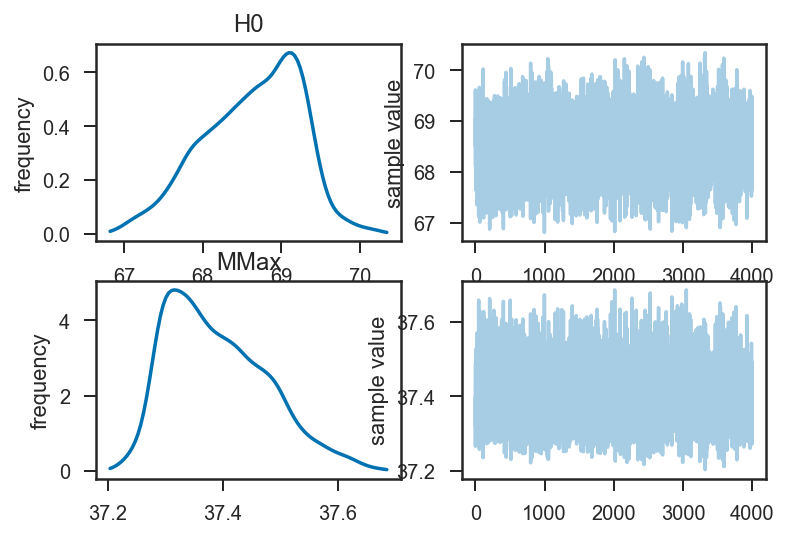

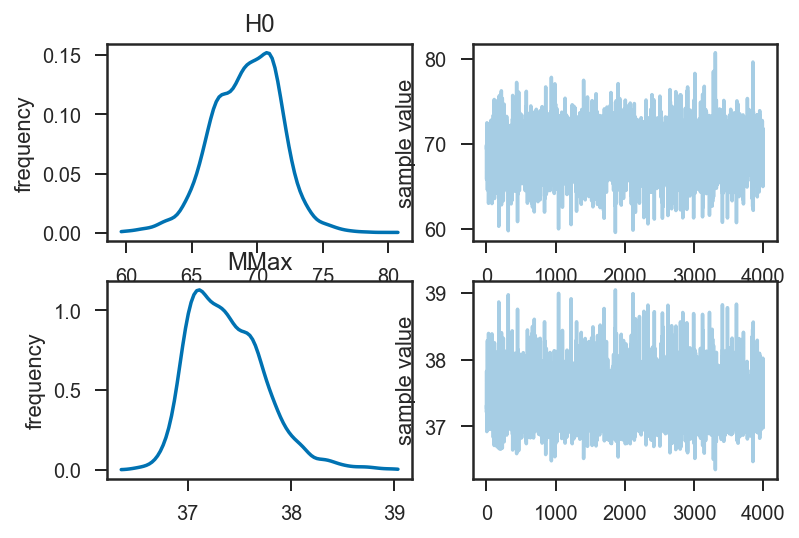

In [30]:
fperfect_full.plot(['H0', 'MMax'])
fperfect_1yr.plot(['H0', 'MMax']);

In [10]:
cperfect_full = fperfect_full.extract()
cperfect_1yr = fperfect_1yr.extract()

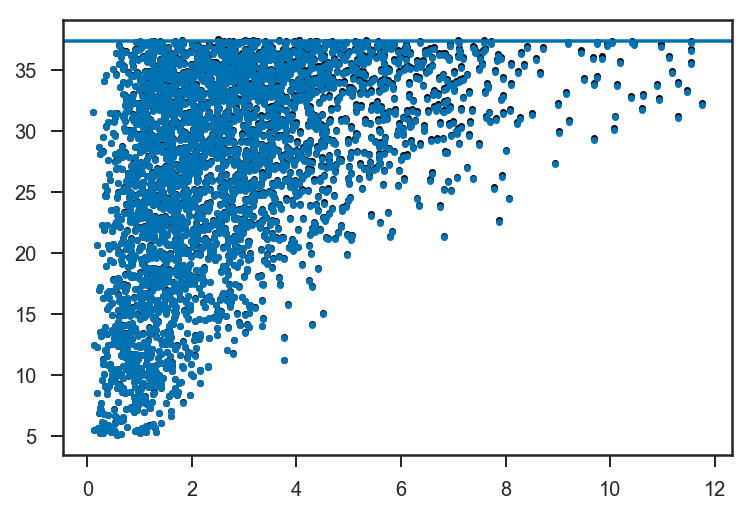

In [11]:
plot(dls, m1s, '.k')
plot(dls, m1s*(1+zs)/(1+cperfect_full['zs'][10,:]), '.')
axhline(cperfect_full['MMax'][10])

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


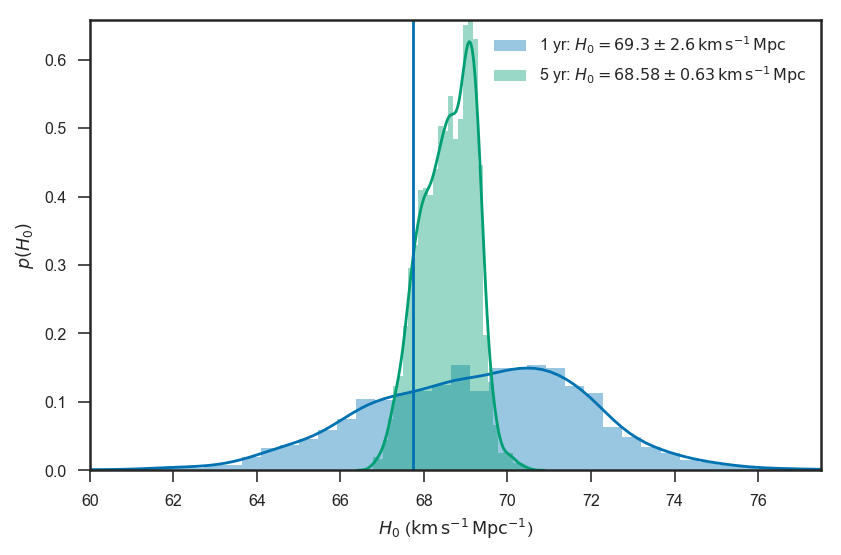

In [23]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):
    sns.distplot(cperfect_1yr['H0'], label=r'1 yr: $H_0 = {:.1f} \pm {:.1f} \, \mathrm{{km}} \, \mathrm{{s}}^{{-1}} \, \mathrm{{Mpc}}$'.format(mean(cperfect_1yr['H0']), std(cperfect_1yr['H0'])))
    sns.distplot(cperfect_full['H0'], label=r'5 yr: $H_0 = {:.2f} \pm {:.2f} \, \mathrm{{km}} \, \mathrm{{s}}^{{-1}} \, \mathrm{{Mpc}}$'.format(mean(cperfect_full['H0']), std(cperfect_full['H0'])))
    axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value)
    xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
    ylabel(r'$p\left( H_0 \right)$')
    legend(loc='best')
    axis(xmin=60, xmax=77.5)
    tight_layout()
    savefig('paper/plots/H0-exact.pdf')
    
    with h5py.File('paper/plots/H0-exact.h5', 'w') as out:
        y1 = out.create_group('1yr')
        y1.create_dataset('H0', data=cperfect_1yr['H0'], shuffle=True, compression='gzip')
        
        f = out.create_group('5yr')
        f.create_dataset('H0', data=cperfect_full['H0'], shuffle=True, compression='gzip')

In [26]:
2.6/69.3, 0.63/68.58

(0.03751803751803752, 0.009186351706036745)

In [19]:
print('H0 = {:.1f} +/- {:.1f} km/s/Mpc (1 years)'.format(mean(cperfect_1yr['H0']), std(cperfect_1yr['H0'])))
print('H0 = {:.2f} +/- {:.2f} km/s/Mpc (5 years)'.format(mean(cperfect_full['H0']), std(cperfect_full['H0'])))

H0 = 69.3 +/- 2.6 km/s/Mpc (1 years)
H0 = 68.58 +/- 0.63 km/s/Mpc (5 years)


Now we begin to account for observational uncertainty.  We will first produce posteriors (with flat priors, so proportional to the likelihoods) on $m_1^\mathrm{obs}$, $m_2^\mathrm{obs}$, and $d_L$; these will approximate the actual PE posteriors one would obtain from analysis of LIGO's data.  Then, posterior (likelihood) samples in hand, we will proceed to compute the population parameters.

In [36]:
model = pystan.StanModel(file='PISNLineParameters.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4093c61ab66f228faa53d5c09e9d0e15 NOW.


For this model, we will need to have the optimal SNR at $d_L = 1 \, \mathrm{Gpc}$ in a grid; the cell below takes a long time to run, but saves its results to disk.  Executing the next cell will re-load the stored data.

In [ ]:
ms = logspace(log10(1), log10(200), 100)
def osnr(m1m2):
    m1, m2 = m1m2
    z = cosmo.z_at_value(Planck15.luminosity_distance, 1*u.Gpc)
    
    # m1, m2 are the *observed* masses, so we need to un-redshift them:
    return vt.optimal_snr(m1/(1+z), m2/(1+z), z, psd_fn=vt.ls.SimNoisePSDaLIGODesignSensitivityP1200087)

M1S, M2S = meshgrid(ms, ms, indexing='ij')

OSNRS = []
for m1,m2 in tqdm_notebook(zip(M1S.ravel(), M2S.ravel())):
    OSNRS.append(osnr((m1,m2)))
OSNRS = array(OSNRS).reshape(M1S.shape)

with h5py.File('optimal_snr.h5', 'w') as out:
    out.create_dataset('ms', data=ms, compression='gzip', shuffle=True)
    out.create_dataset('SNR', data=OSNRS, compression='gzip', shuffle=True)

Run this cell to re-load the optimal SNR grid.

In [5]:
with h5py.File('optimal_snr.h5', 'r') as inp:
    ms = array(inp['ms'])
    OSNRS = array(inp['SNR'])
M1S, M2S = meshgrid(ms, ms, indexing='ij')

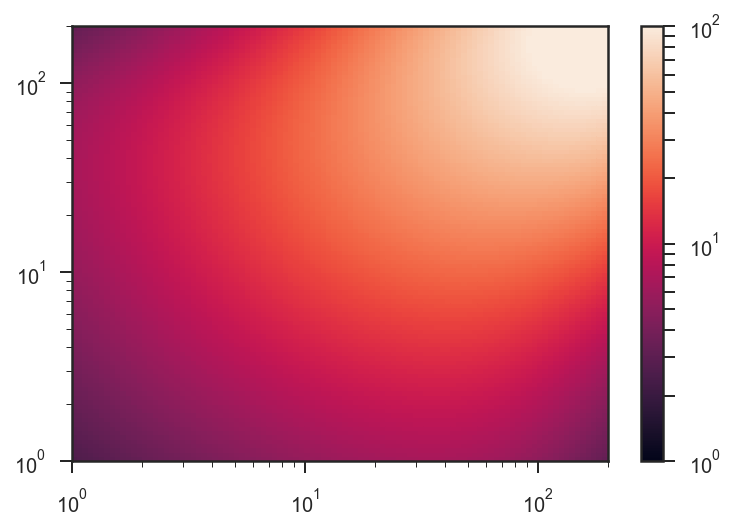

In [6]:
pcolormesh(M1S, M2S, OSNRS, norm=LogNorm(), vmin=1, vmax=100)
colorbar()
xscale('log')
yscale('log')

In [8]:
dl_max = Planck15.luminosity_distance(2.0).to(u.Gpc).value

We are going to impose a prior on theta that is simple and approximately represents the distribution of thetas.  We choose a Gaussian with moments matched to the actual theta distribution:

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


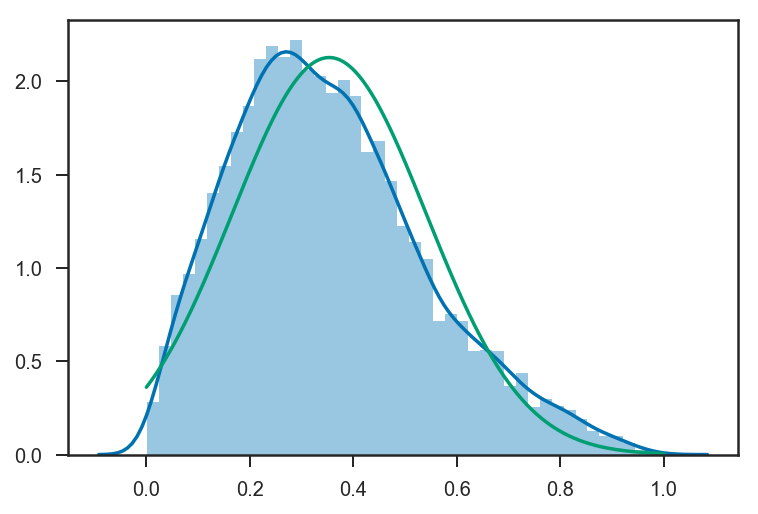

In [35]:
sns.distplot(vt.thetas)

mu = mean(vt.thetas)
sig = std(vt.thetas)

xs = linspace(0, 1, 1000)
plot(xs, ss.norm(loc=mu, scale=sig).pdf(xs))

In [37]:
chain = {'m1s': zeros((0, 4000)),
         'm2s': zeros((0, 4000)),
         'mcs': zeros((0, 4000)),
         'etas': zeros((0, 4000)),
         'qs': zeros((0, 4000)),
         'dLs': zeros((0, 4000)),
         'opt_snrs': zeros((0, 4000)),
         'thetas': zeros((0,4000))}

mut = np.mean(vt.thetas)
sigt = np.std(vt.thetas)

for i in tnrange(len(m1s)):
    d = {
        'mc_obs': mc_obs[i],
        'eta_obs': eta_obs[i],
        'A_obs': A_obs[i],
        'theta_obs': theta_obs[i],
        
        'sigma_mc': sigma_mc[i],
        'sigma_eta': sigma_eta[i],
        'sigma_theta': sigma_theta[i],
        
        'nm': len(ms),
        'ms': ms,
        'opt_snrs': OSNRS,
        
        'dL_max': dl_max,
        'mu_theta': mut,
        'sig_theta': sigt
    }
    init = {
        'm1': m1s[i],
        'm2': m2s[i],
        'dL': dls[i],
        'theta': thetas[i]
    }
    iter = 2000
    thin = 1
    while True:
        f = model.sampling(data=d, iter=iter, thin=thin, init=(init,)*4)
        
        # Iterate with more samples if Rhat > 1.1 for any parameter.
        if np.any(f.summary()['summary'][:,-1] > 1.1):
            iter *= 2
            thin *= 2
            warnings.warn('re-doing sampling with more iterations: {:d}'.format(iter))
        else:
            break
    c = f.extract(permuted=True)
    
    for n in ['m1', 'm2', 'mc', 'eta', 'dL', 'opt_snr', 'theta']:
        ns = n + 's'
        chain[ns] = row_stack((chain[ns], c[n]))

with h5py.File('parameters.h5', 'w') as out:
    out.attrs['Tobs'] = 5*duty_cycle
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        out.create_dataset(n, data=chain[n], compression='gzip', shuffle=True)
with h5py.File('parameters_1yr.h5', 'w') as out:
    out.attrs['Tobs'] = 1*duty_cycle
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        out.create_dataset(n, data=chain[n][:N_1yr,:], compression='gzip', shuffle=True)
with h5py.File('parameters_small.h5', 'w') as out:
    out.attrs['Tobs'] = 0.1*duty_cycle
    N_0p1yr = int(round(N_1yr/10.0))
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        out.create_dataset(n, data=chain[n][:N_0p1yr,:], compression='gzip', shuffle=True)

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing samplin

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iteration

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:46: UserWarning: re-doing sampling with more iterations: 4000


In [131]:
chain = {}
with h5py.File('parameters.h5', 'r') as inp:
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        chain[n] = array(inp[n])
chain_1yr = {}
with h5py.File('parameters_1yr.h5', 'r') as inp:
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        chain_1yr[n] = array(inp[n])
chain_small = {}
with h5py.File('parameters_small.h5', 'r') as inp:
    for n in ['m1s', 'm2s', 'mcs', 'etas', 'dLs', 'opt_snrs', 'thetas']:
        chain_small[n] = array(inp[n])

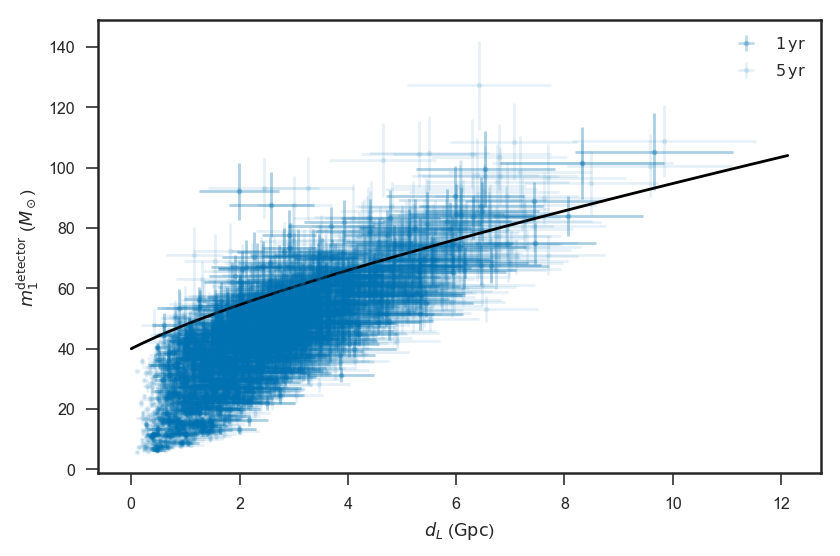

In [6]:
with sns.plotting_context('paper', rc={'figure.figsize': figsize_pub}):
    m1o = chain_1yr['m1s']
    dlo = chain_1yr['dLs']

    m1a = chain['m1s']
    dla = chain['dLs']

    errorbar(np.mean(dlo, axis=1), np.mean(m1o, axis=1), xerr=std(dlo, axis=1), yerr=std(m1o, axis=1), fmt='.', label=r'$1 \, \mathrm{yr}$', alpha=0.25)
    errorbar(np.mean(dla, axis=1), np.mean(m1a, axis=1), xerr=std(dla, axis=1), yerr=std(m1a, axis=1), fmt='.', color=sns.color_palette()[0], alpha=0.1, label=r'$5 \, \mathrm{yr}$')

    z = linspace(0, 1.6, 100)
    dl = Planck15.luminosity_distance(z).to(u.Gpc).value

    plot(dl, 40*(1+z), '-k')

    legend(loc='best')
    
    xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
    ylabel(r'$m_1^\mathrm{detector}$ ($M_\odot$)')
    
    tight_layout()
    savefig('paper/plots/m1-dL-obs.pdf')
    
    with h5py.File('paper/plots/m1-dL-obs.h5', 'w') as out:
        def cd(g, n, d):
            g.create_dataset(n, data=d, compression='gzip', shuffle=True)
        g1 = out.create_group('1yr')
        cd(g1, 'dl_mean', mean(dlo, axis=1))
        cd(g1, 'dl_std', std(dlo, axis=1))
        cd(g1, 'm1_mean', mean(m1o, axis=1))
        cd(g1, 'm1_std', std(m1o, axis=1))
        
        g5 = out.create_group('5yr')
        cd(g5, 'dl_mean', mean(dla, axis=1))
        cd(g5, 'dl_std', std(dla, axis=1))
        cd(g5, 'm1_mean', mean(m1a, axis=1))
        cd(g5, 'm1_std', std(m1a, axis=1))
        
        c = out.create_group('cosmology')
        cd(c, 'dls', dl)
        cd(c, 'MMax', 40*(1+z))

Let's just check the uncertainty that is produced in our simulations.  For GW170814, we have 

* $m_1 = 30.5^{+5.7}_{-3.0} \, M_\odot$
* $d_L = 540^{+130}_{-210} \, \mathrm{Mpc}$

both at 90% CL.  That corresponds to a range in $\log m_1$ of $\Delta_{90} \log m_1 = 0.27$ and a range of $d_L$ of $\Delta_{90} d_L = 0.71$.  How does this compare to a typical and marginal detected event from our sample?

In [11]:
delta90_logm1 = log(percentile(chain['m1s'], 95, axis=1))-log(percentile(chain['m1s'], 5, axis=1))
delta90_logdl = log(percentile(chain['dLs'], 95, axis=1))-log(percentile(chain['dLs'], 5, axis=1))

In [12]:
print('median d90(log(m1)) = {:.2f}'.format(median(delta90_logm1)))
print('95th percentile d90(log(m1)) = {:.2f}'.format(percentile(delta90_logm1, 95)))

median d90(log(m1)) = 0.31
95th percentile d90(log(m1)) = 0.43


In [13]:
print('median d90(log(dl)) = {:.2f}'.format(median(delta90_logdl)))
print('95th percentile d90(log(dl)) = {:.2f}'.format(percentile(delta90_logdl, 95)))

median d90(log(dl)) = 0.58
95th percentile d90(log(dl)) = 1.03


It is fun to look at some of the inferences; execute the cell below to view a random event in $m_1$-$m_2$-$d_L$ space.  You can also change the number of samples used to construct the density.

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'color',

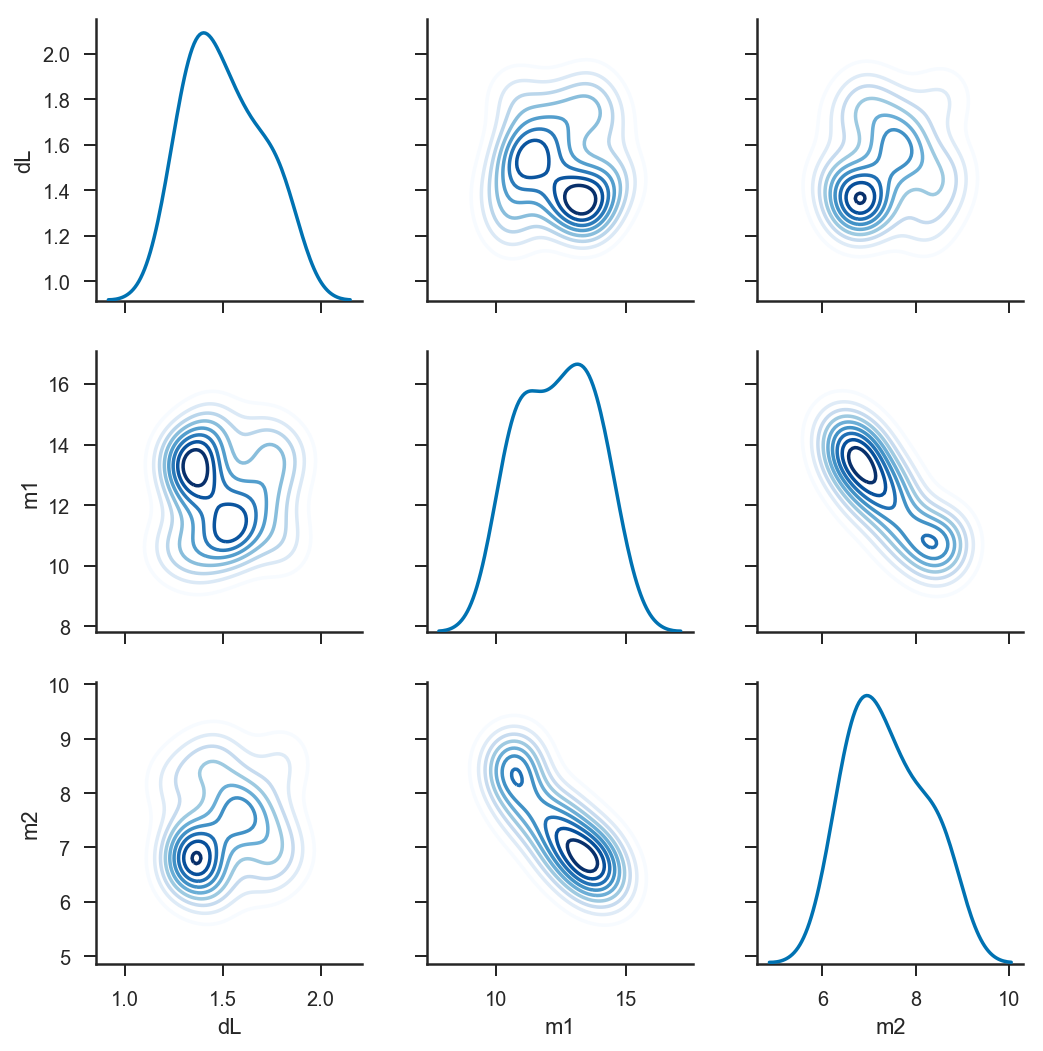

In [16]:
i = randint(chain['m1s'].shape[0])
n = 16
s = random.choice(chain['m1s'].shape[1], replace=False, size=n)

df = pandas.DataFrame({'m1': chain['m1s'][i,s],
                       'm2': chain['m2s'][i,s],
                       'dL': chain['dLs'][i,s]})

g = sns.PairGrid(df, diag_sharey=False)
g.map_offdiag(sns.kdeplot, cmap='Blues')
g.map_diag(sns.kdeplot)

From the errorbar population plot above, it is clear that we will need to model the population in order to get the most from this data set; simply doing a linear regression is likely to be biased because the population prior is *not* flat in $m_1$, $q$, and $d_L$.  If we are going to model the population, selection effects will become important, so let's produce a sample of selected systems drawn flat in $m_1^\mathrm{obs}$, $q$, and $d_L$ so we can Monte-Carlo the selection integral.  Based on experiments, we will want the variance in the selection function integral to be much smaller than the statistical variance of the measurement on $H_0$; this will require at least an order of magnitude more systems drawn for the selection function than actually observed, since these events get non-uniformly weighted.

We want to generate systems between the following masses and distances:

In [109]:
np.min(chain['m2s']), np.max(chain['m1s']), np.max(chain['dLs'])

(3.162933091146668, 176.90795315367188, 15.911095092262359)

We can run the below for a bit, and then extended the selected set of systems using the auxllary application `extend_selected.py` (e.g. on a cluster).

In [ ]:
N_selection = 16384

dLmax = 1.2*np.max(chain['dLs'])

MObsMin = 0.5*np.min(chain['m2s'])
MObsMax = 1.2*np.max(chain['m1s'])

m1s_det = []
m2s_det = []
dls_det = []
wts_det = []
N_gen = 0
N_det = 0

ts = concatenate(([0.0], sort(vt.thetas), [1.0]))

tcum = interp1d(linspace(0, 1, ts.shape[0]), ts)

oi = interp2d(M1S, M2S, OSNRS)

def wt_fn(m1obs, m2obs, dlobs):
    m1wt = 1.0/(m1obs*(log(MObsMax) - log(MObsMin)))
    m2wt = 1.0/(m1obs - MObsMin)
    
    dlwt = 3.0*dlobs**2/dLmax**3
    
    return m1wt*m2wt*dlwt

with tqdm_notebook(total=N_selection) as bar:
    while N_det < N_selection:
        N_gen += 1
        m1obs = exp(random.uniform(low=log(MObsMin), high=log(MObsMax)))
        m2obs = random.uniform(low=MObsMin, high=m1obs)
                
        dl = dLmax*cbrt(rand())

        opt_snr = oi(m1obs, m2obs)/dl

        th = tcum(rand())

        A = th * opt_snr

        sa = 1.0
        st = 0.15*8.0/A

        Aobs = random.normal(loc=A, scale=sa)

        if Aobs > 8:     
            N_det += 1
            bar.update(1)
            
            m1s_det.append(m1obs)
            m2s_det.append(m2obs)
            dls_det.append(dl)
            wts_det.append(wt_fn(m1obs, m2obs, dl))

with h5py.File('selected.h5', 'w') as out:
    out.attrs['MObsMin'] = MObsMin
    out.attrs['MObsMax'] = MObsMax
    out.attrs['dLMax'] = dLmax
    out.attrs['NGen'] = N_gen
    
    for n, d in (('m1', m1s_det), ('m2', m2s_det), ('dl', dls_det), ('wt', wts_det)):
        out.create_dataset(n, data=array(d), compression='gzip', shuffle=True)

Executing the cell below will re-load the detected set of systems; we are going to go for overkill, and choose to have more than 400k detected systems (this is more than an order of magnitude larger than the number of systems we have in the 5-year data set).

In [125]:
with h5py.File('selected.h5', 'r') as inp:
    MObsMin = inp.attrs['MObsMin']
    MObsMax = inp.attrs['MObsMax']
    dLmax = inp.attrs['dLMax']
    N_gen = inp.attrs['NGen']
    
    m1s_det = array(inp['m1'])
    m2s_det = array(inp['m2'])
    dls_det = array(inp['dl'])
    wts_det = array(inp['wt'])

Here we check the variance in the $\left\langle N \right\rangle$ calculation for the true parameters given our data set of selected systems.

In [133]:
def Ez(z):
    Om = Planck15.Om0
    return sqrt(Om*(1+z)**3 + (1-Om))

def dzddL(dl, z, dH):
    return 1.0/(dl/(1+z) + (1+z)*dH/Ez(z))

def dNdm1dm2ddLdt(m1, m2, dl, z, R0, MMin, MMax, alpha, beta, gamma, dH):
    m1norm = (1-alpha)/(MMax**(1-alpha) - MMin**(1-alpha))
    m2norm = (1+beta)/(m1**(1+beta) - MMin**(1+beta))
    
    dNdm1dm2dVdt = R0 * m1**(-alpha) * m2**(beta) * m1norm * m2norm * (1+z)**(gamma-1)
    
    dNdm1dm2dzdt = dNdm1dm2dVdt * 4.0*pi*(dl/(1+z))**2*dH/Ez(z)
    
    dNdm1dm2ddLdt = dNdm1dm2dzdt * dzddL(dl, z, dH)
    
    dNdm1dm2ddLdt[(m1>MMax) | (m2<MMin)] = 0
    
    return dNdm1dm2ddLdt

zinterp = linspace(0, 5, 1000)
dlinterp = Planck15.luminosity_distance(zinterp).to(u.Gpc).value

zs_det = interp1d(dlinterp, zinterp)(dls_det)
fs = dNdm1dm2ddLdt(m1s_det/(1+zs_det), m2s_det/(1+zs_det), dls_det, zs_det, 100.0, MMin, MMax, alpha, beta, 3.0, Planck15.hubble_distance.to(u.Gpc).value)
fs = fs / (1+zs_det)**2
fs = fs / wts_det

It appears that we have about 3% uncertainty on the expected number, which should be sufficient for our purposes.

In [134]:
uncert = sqrt(fs.shape[0])*std(fs)/sum(fs)
Neff = 1.0/(uncert*uncert)

print('Uncertainty on selection integral is {:.3f}; Neff = {:.1f}'.format(uncert, Neff))

Uncertainty on selection integral is 0.089; Neff = 126.4


In [128]:
chain['m1s'].shape

(3199, 4000)

Here is the spacing between detected samples as a function of mass; we use $m_1$ to determine the spacing at high mass and $m_2$ to determine the spacing at low mass.

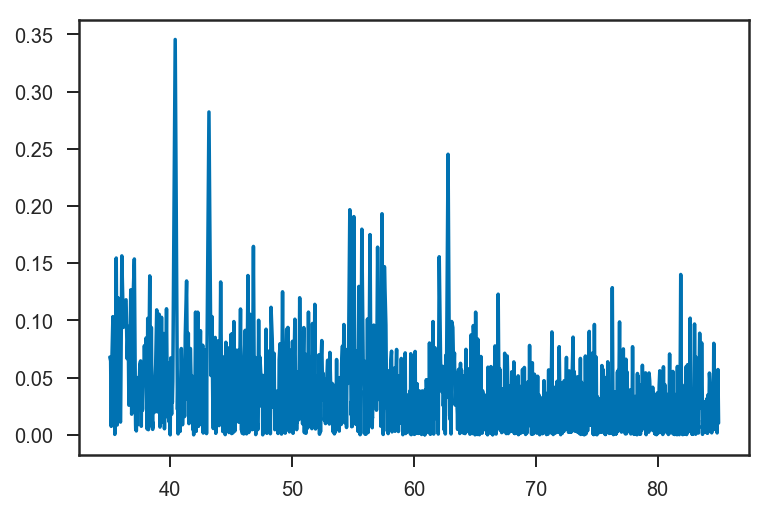

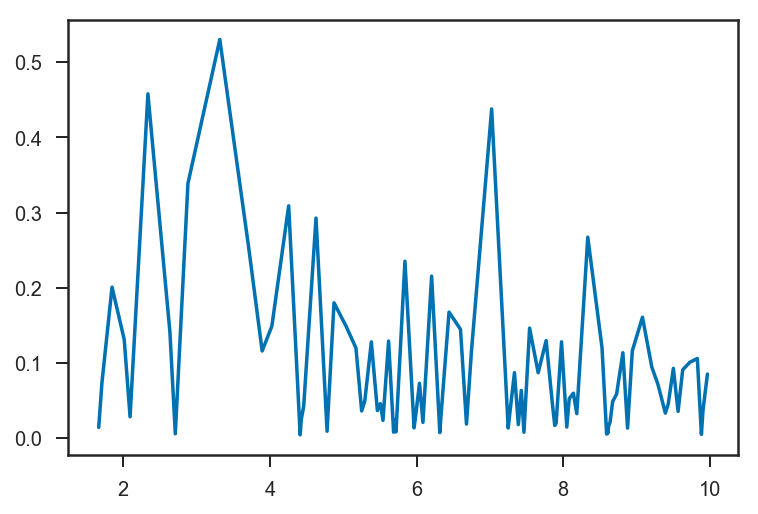

In [21]:
m = sort(m1s_det)
x = 0.5*(m[:-1]+m[1:])
y = diff(m)

figure()
s = (35 < x) & (x < 85)
plot(x[s],y[s])

m = sort(m2s_det)
x = 0.5*(m[:-1] + m[1:])
y = diff(m)

figure()
s = (1 < x) & (x < 10)
plot(x[s],y[s])

Let's see how many samples we will need to ensure that, at the true $H_0$, we have some sample below the true maximum mass.  From the below, we will see that there is at least one event that will not have *any* samples below the true maximum mass!

In [19]:
dlmax = max(np.max(chain['dLs']), np.max(dls_det))
dli = linspace(1e-3, 1.1*dlmax, 1000)
zi = array([cosmo.z_at_value(Planck15.luminosity_distance, d*u.Gpc) for d in dli])

z = interp1d(dli, zi)(chain['dLs'])

m1 = chain['m1s']/(1+z)

imax = np.argmax(np.min(m1, axis=1))
mmax_sample = np.min(m1, axis=1)[imax]

print('MMax from sampling at true H0 is {:.1f}'.format(mmax_sample))

MMax from sampling at true H0 is 41.0


So, we need to interpolate somehow on the likelihood, or we will have ruled out the true maximum mass.  The cell below gives the maximum values of the minimum mass samples over events and also the standard deviation of the Scott's rule KDE for that event.  For fewer than ~128 samples, the true minimum mass is more than 3-sigma away from the smallest mass sample (so the runs are likely to be biased to smaller values of $H_0$).  We can confirm this by comparing runs with different numbers of samples and checking when convergence is achieved.

In [36]:
n = 128
dli = linspace(0, max(np.max(chain['dLs']), np.max(dls_det)), 250)
zi = array([0.0] + [cosmo.z_at_value(Planck15.luminosity_distance, d*u.Gpc) for d in dli[1:]])

z = interp1d(dli, zi)(chain['dLs'][:,:n])
m1 = chain['m1s'][:,:n]/(1+z)

i = np.argmax(np.min(m1, axis=1))
mm = np.min(m1, axis=1)[i]
sm = np.std(m1, axis=1)[i]/n**(1.0/5.0)

mm, sm, MMax, (mm-MMax)/sm

(47.93941095885602, 3.7967128319117287, 37.5, 2.7495919288685178)

Here is where the rubber meets the road; the fitting is done in the ``fit.py`` script for both one year (below) and five years' data (further on).

In [36]:
chain_pop_1yr = {}
n2best = 256
nbest = 512
for nn in [nbest, n2best]:
    c = {}
    with h5py.File('population_1yr_{:04d}_vb.h5'.format(nn), 'r') as inp:
        for n in ['H0', 'R0', 'MMax', 'MMin', 'alpha', 'beta', 'gamma']:
            c[n] = array(inp[n])
    chain_pop_1yr[nn] = c

Let's check the corner plot for the largest number of samples in a run:

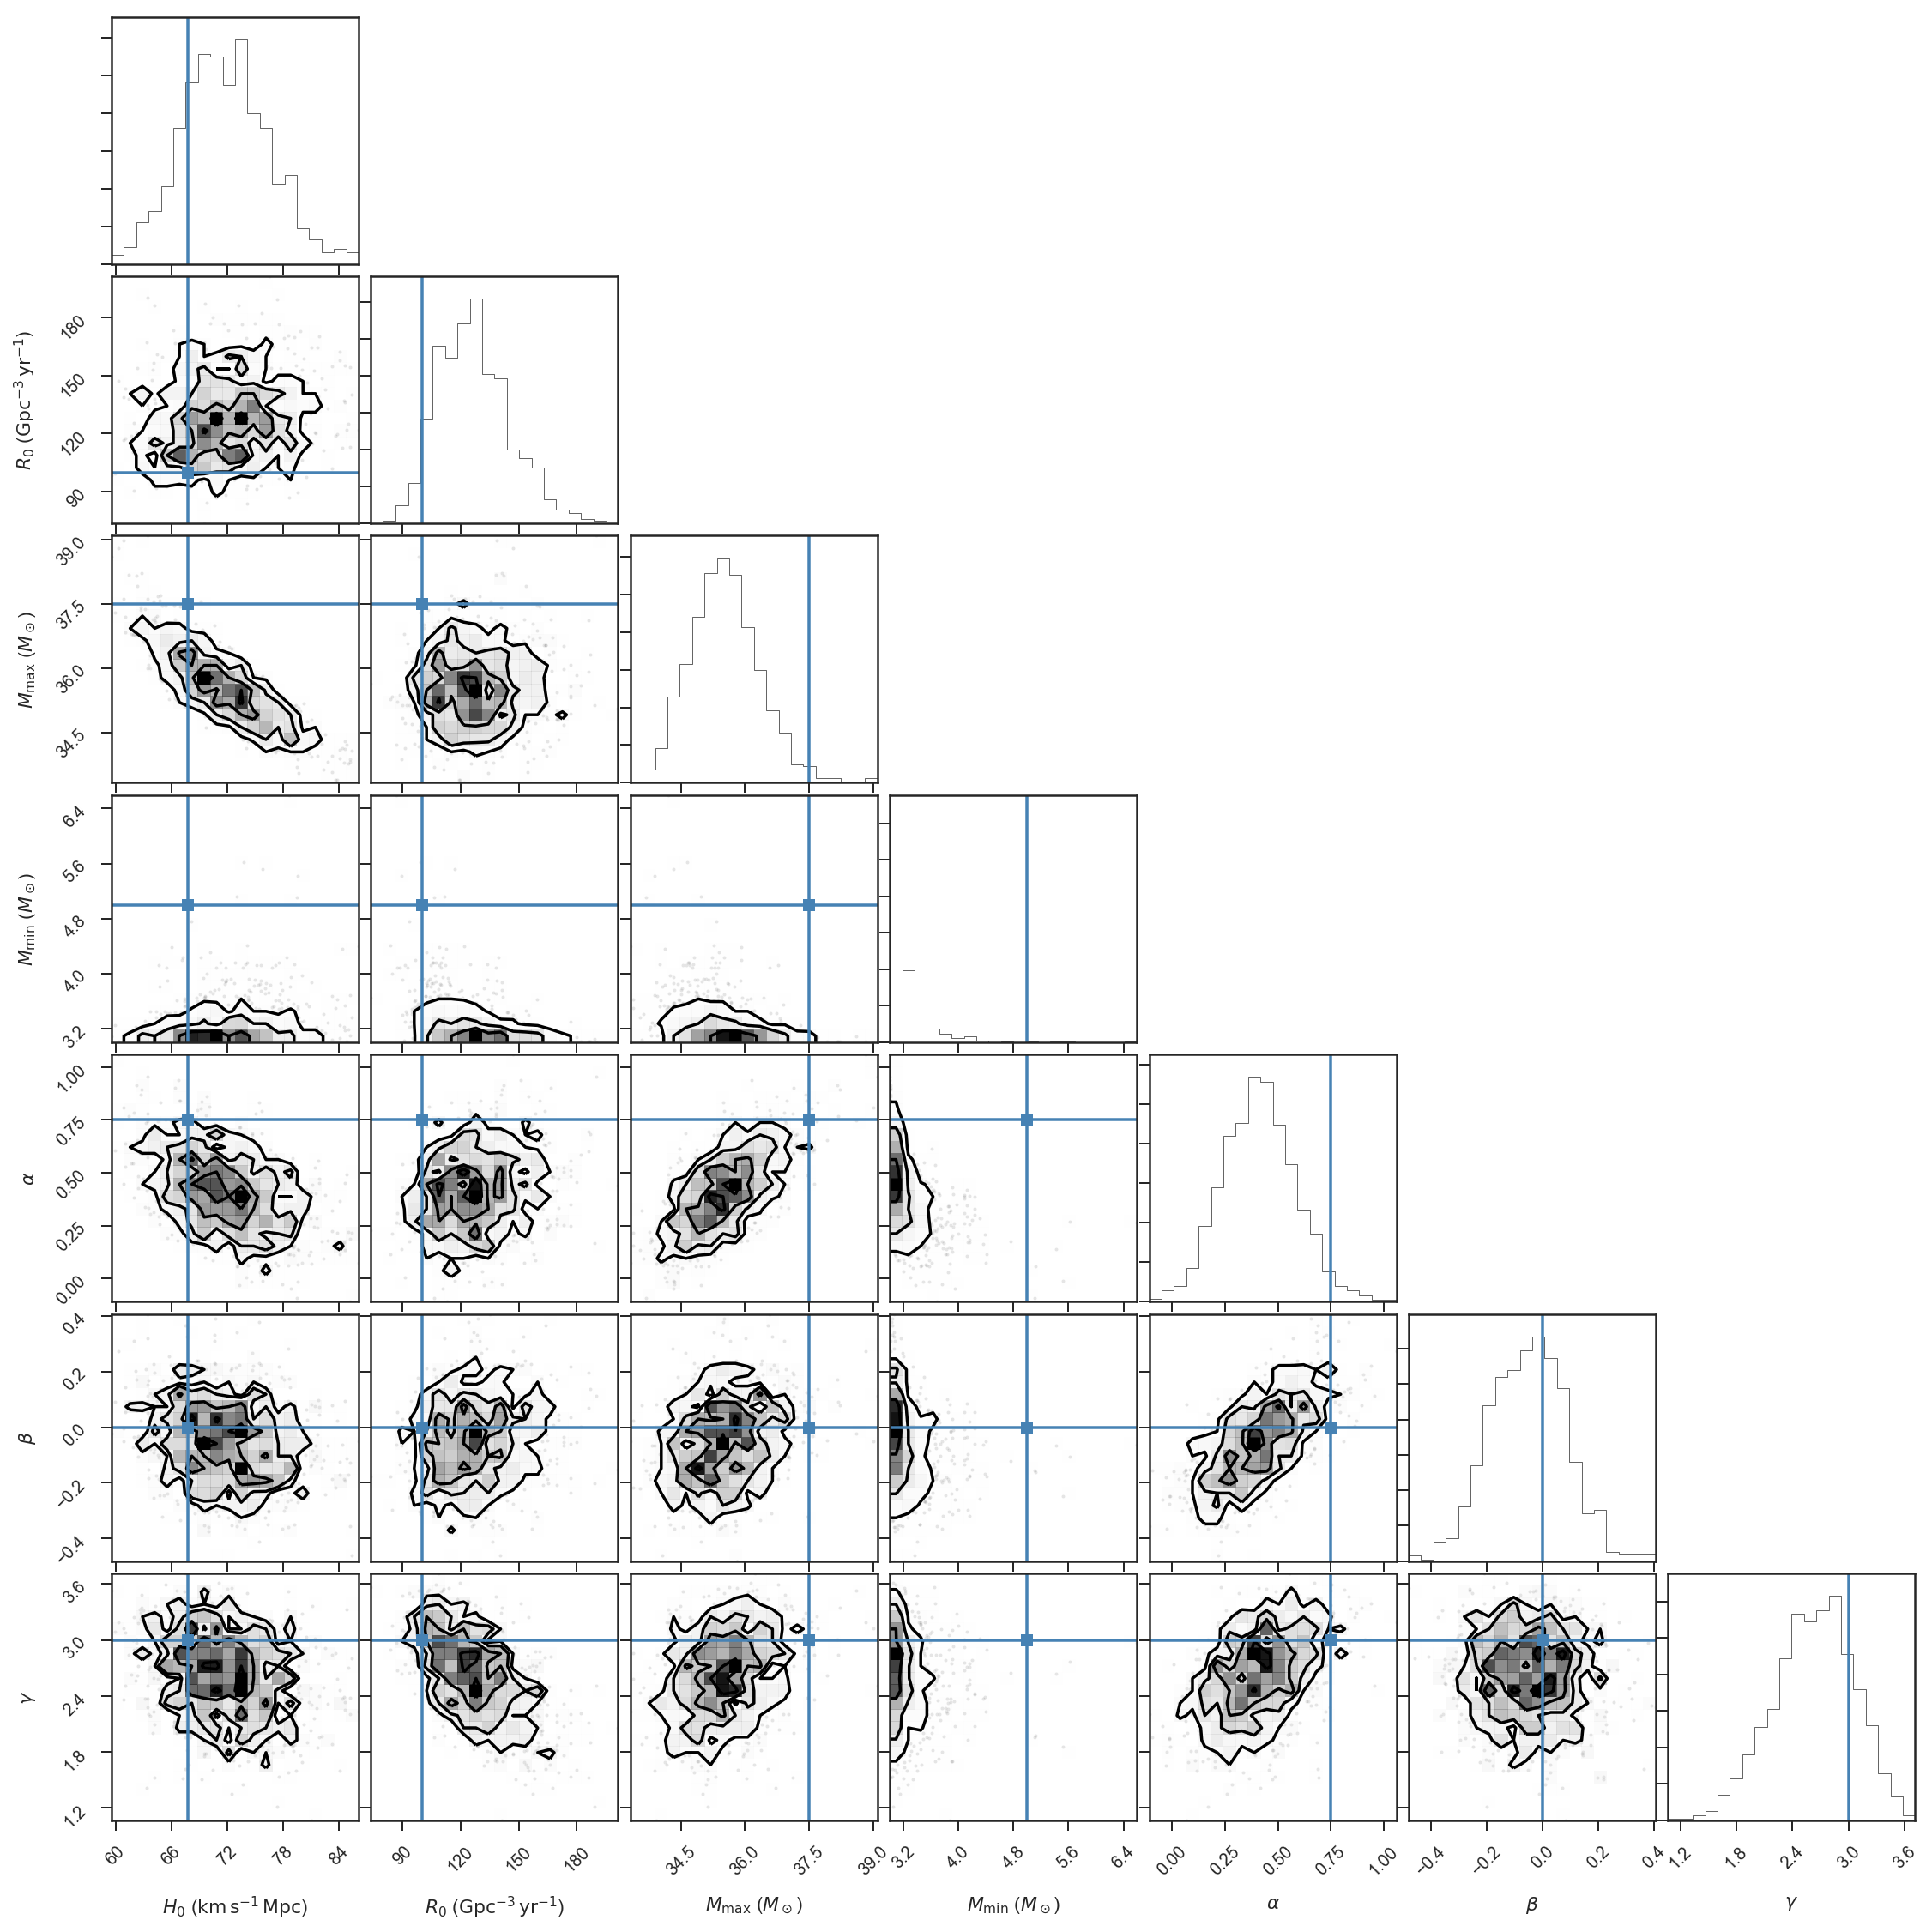

In [37]:
corner.corner(column_stack([chain_pop_1yr[nbest][n] for n in ['H0', 'R0', 'MMax', 'MMin', 'alpha', 'beta', 'gamma']]), 
              labels=[r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}$)', 
                      r'$R_0$ ($\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$)', 
                      r'$M_\mathrm{max}$ ($M_\odot$)',
                      r'$M_\mathrm{min}$ ($M_\odot$)',
                      r'$\alpha$',
                      r'$\beta$',
                      r'$\gamma$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, 
                      100.0,
                      MMax,
                      MMin,
                      alpha,
                      beta,
                      3]);

This will efficiently find the shortest posterior interval in 1D that contains the given fraction of samples.

In [38]:
def spd_interval(samps, p):
    samps = sort(samps)
    N = samps.shape[0]
    Nint = int(round(p*N))
    Nout = N-Nint
    
    starts = samps[0:Nout]
    ends = samps[N-Nout:N]
    
    i = np.argmin(ends - starts)

    return starts[i], ends[i]

Here is the H0 plot; black line is "truth" (from ``Planck15``), blue line is posterior median, dashed is 68% CI, and dotted is 95% CI.

H0 = 71.6 + 4.5 - 4.5 km/s/Mpc (1-sigma) after one year
1-sigma interval is 4.5


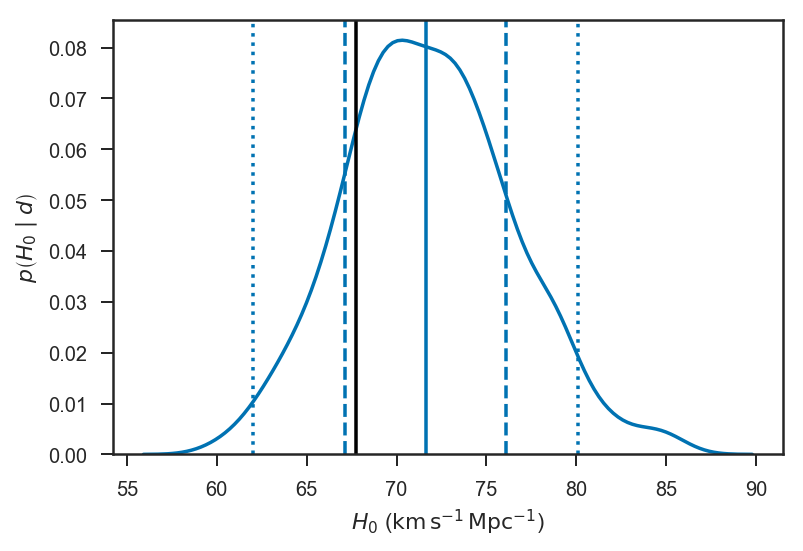

In [39]:
sns.kdeplot(chain_pop_1yr[nbest]['H0'])
xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
ylabel(r'$p\left( H_0 \mid d \right)$')
axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')

m = median(chain_pop_1yr[nbest]['H0'])
l, h = spd_interval(chain_pop_1yr[nbest]['H0'], 0.68)
ll, hh = spd_interval(chain_pop_1yr[nbest]['H0'], 0.95)

axvline(m)
axvline(l, ls='--')
axvline(h, ls='--')
axvline(ll, ls=':')
axvline(hh, ls=':')

dl = m-l
dh = h - m

print('H0 = {:.1f} + {:.1f} - {:.1f} km/s/Mpc (1-sigma) after one year'.format(m, dl, dh))
print('1-sigma interval is {:.1f}'.format((h-l)/2))

Text(0,0.5,'$m_1$ ($M_\\odot$)')

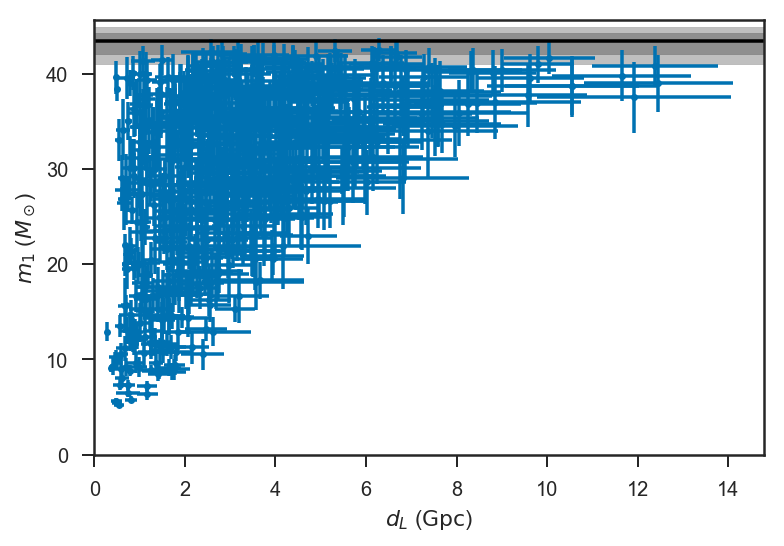

In [17]:
c = chain_pop_1yr[nbest]

m1 = mean(c['m1_true'], axis=0)
sm1 = std(c['m1_true'], axis=0)

dl = mean(c['dl_true'], axis=0)
sdl = std(c['dl_true'], axis=0)

errorbar(dl, m1, xerr=sdl, yerr=sm1, fmt='.')

gca().set_xlim(left=0)
gca().set_ylim(bottom=0)

xl, xh = gca().get_xlim()

plot([xl,xh], median(c['MMax'])*ones(2), color='k', ls='-')
fill_between([xl,xh], percentile(c['MMax'], 84), percentile(c['MMax'], 16), alpha=0.25, color='k')
fill_between([xl,xh], percentile(c['MMax'], 97.5), percentile(c['MMax'], 2.5), alpha=0.25, color='k')

xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
ylabel(r'$m_1$ ($M_\odot$)')

To check that we have converged in the required number of samples, here is a comparison of all the 1D population-level posteriors with the two largest number of samples per event.

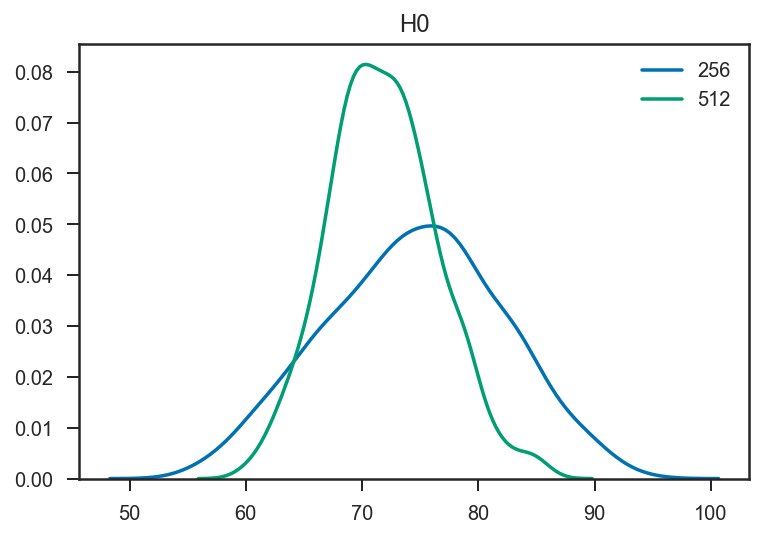

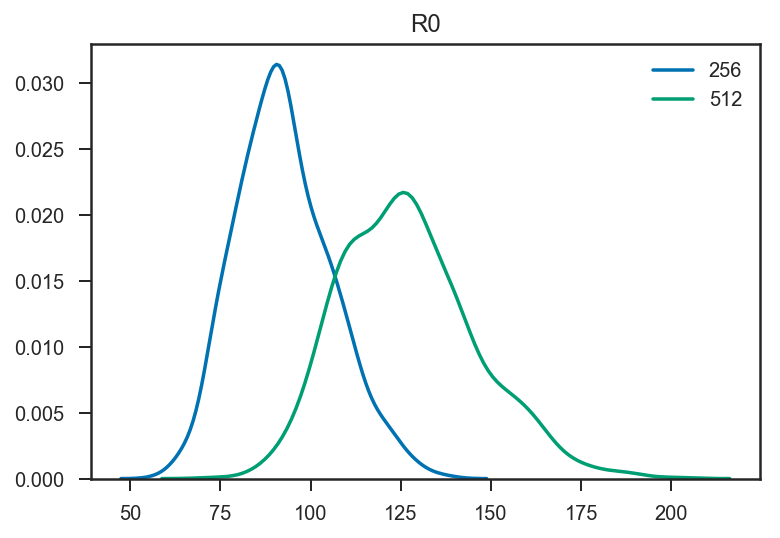

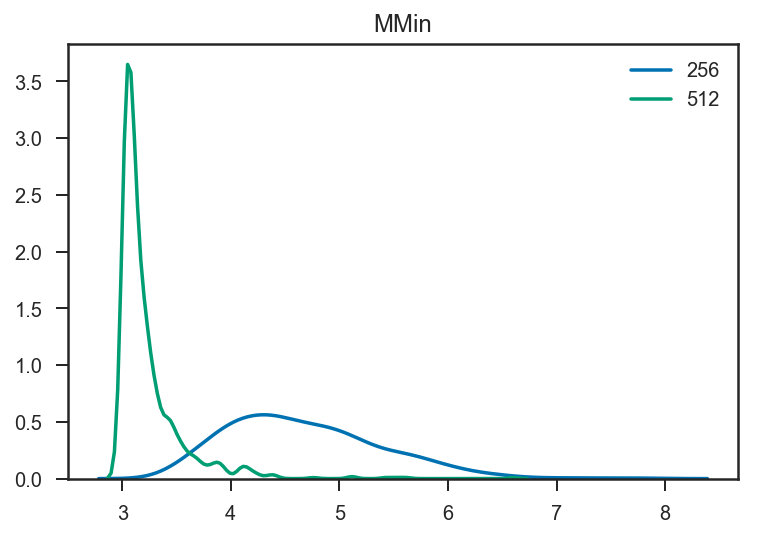

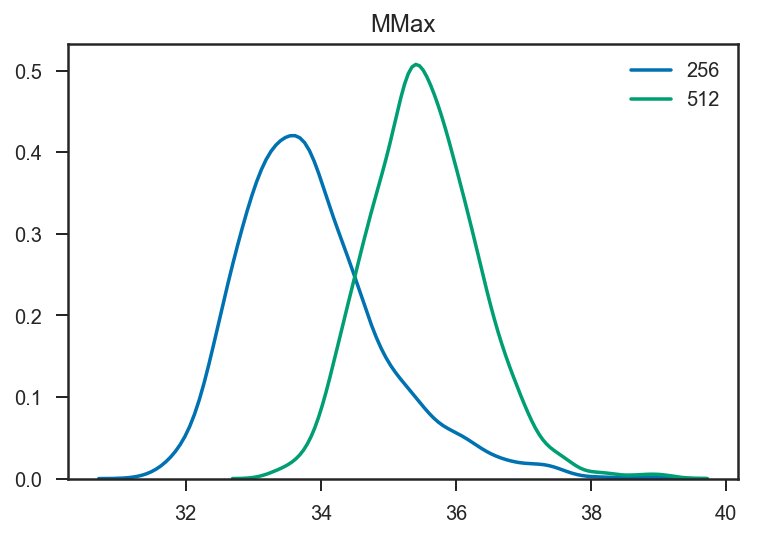

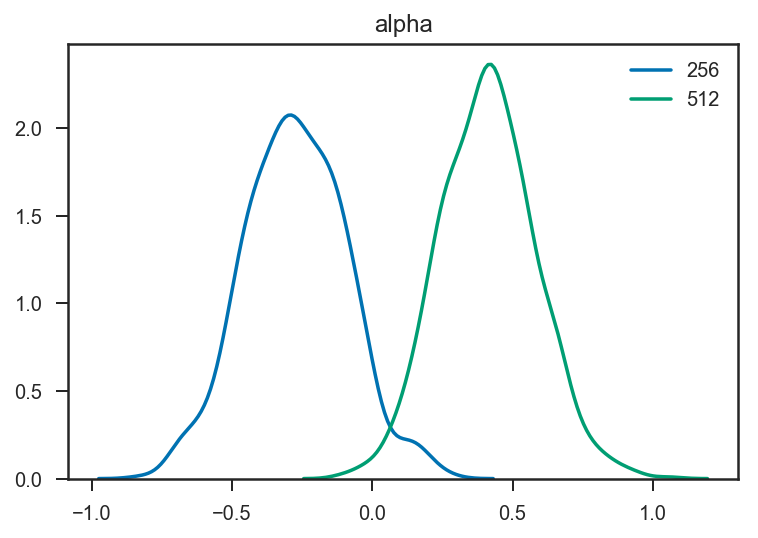

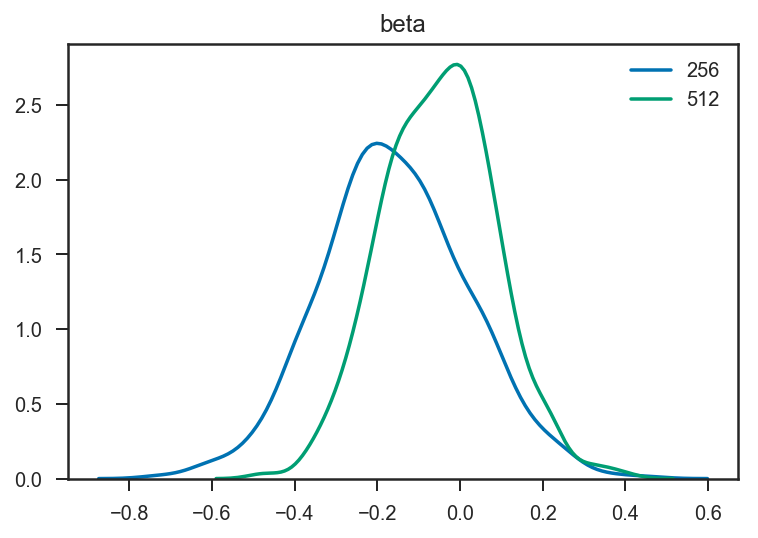

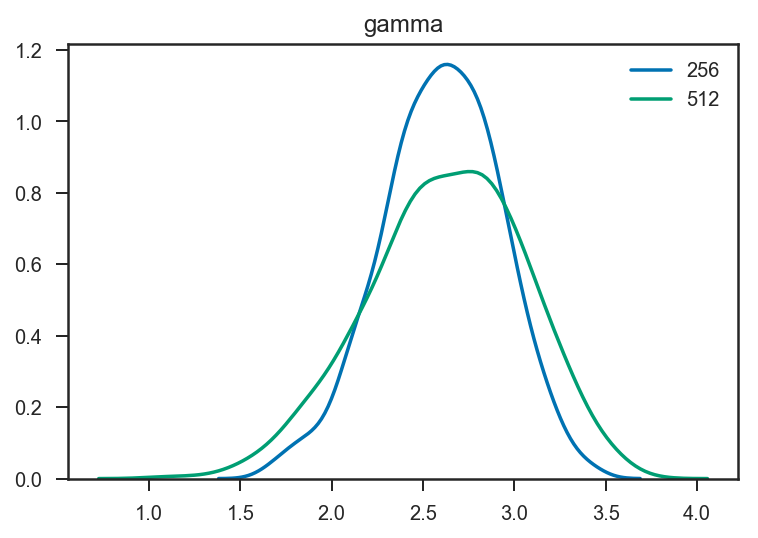

In [40]:
for n in ['H0', 'R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma']:
    figure()
    title(n)
    for nn in [n2best, nbest]:
        c = chain_pop_1yr[nn][n]
        sns.kdeplot(c, label=str(nn))
    legend(loc='best')

Now the same for 5 years of data (coming soon).

In [82]:
chain_pop_5yr = {}
nbest = 16
#n2best = 400
for nn in [nbest]:#, n2best]:
    c = {}
    with h5py.File('population_5yr_{:04d}.h5'.format(nn), 'r') as inp:
        for n in ['H0', 'R0', 'MMax', 'MMin', 'alpha', 'beta', 'gamma', 'm1s_true', 'm2s_true', 'dls_true', 'zs_true']:
            c[n] = array(inp[n])
    chain_pop_5yr[nn] = c

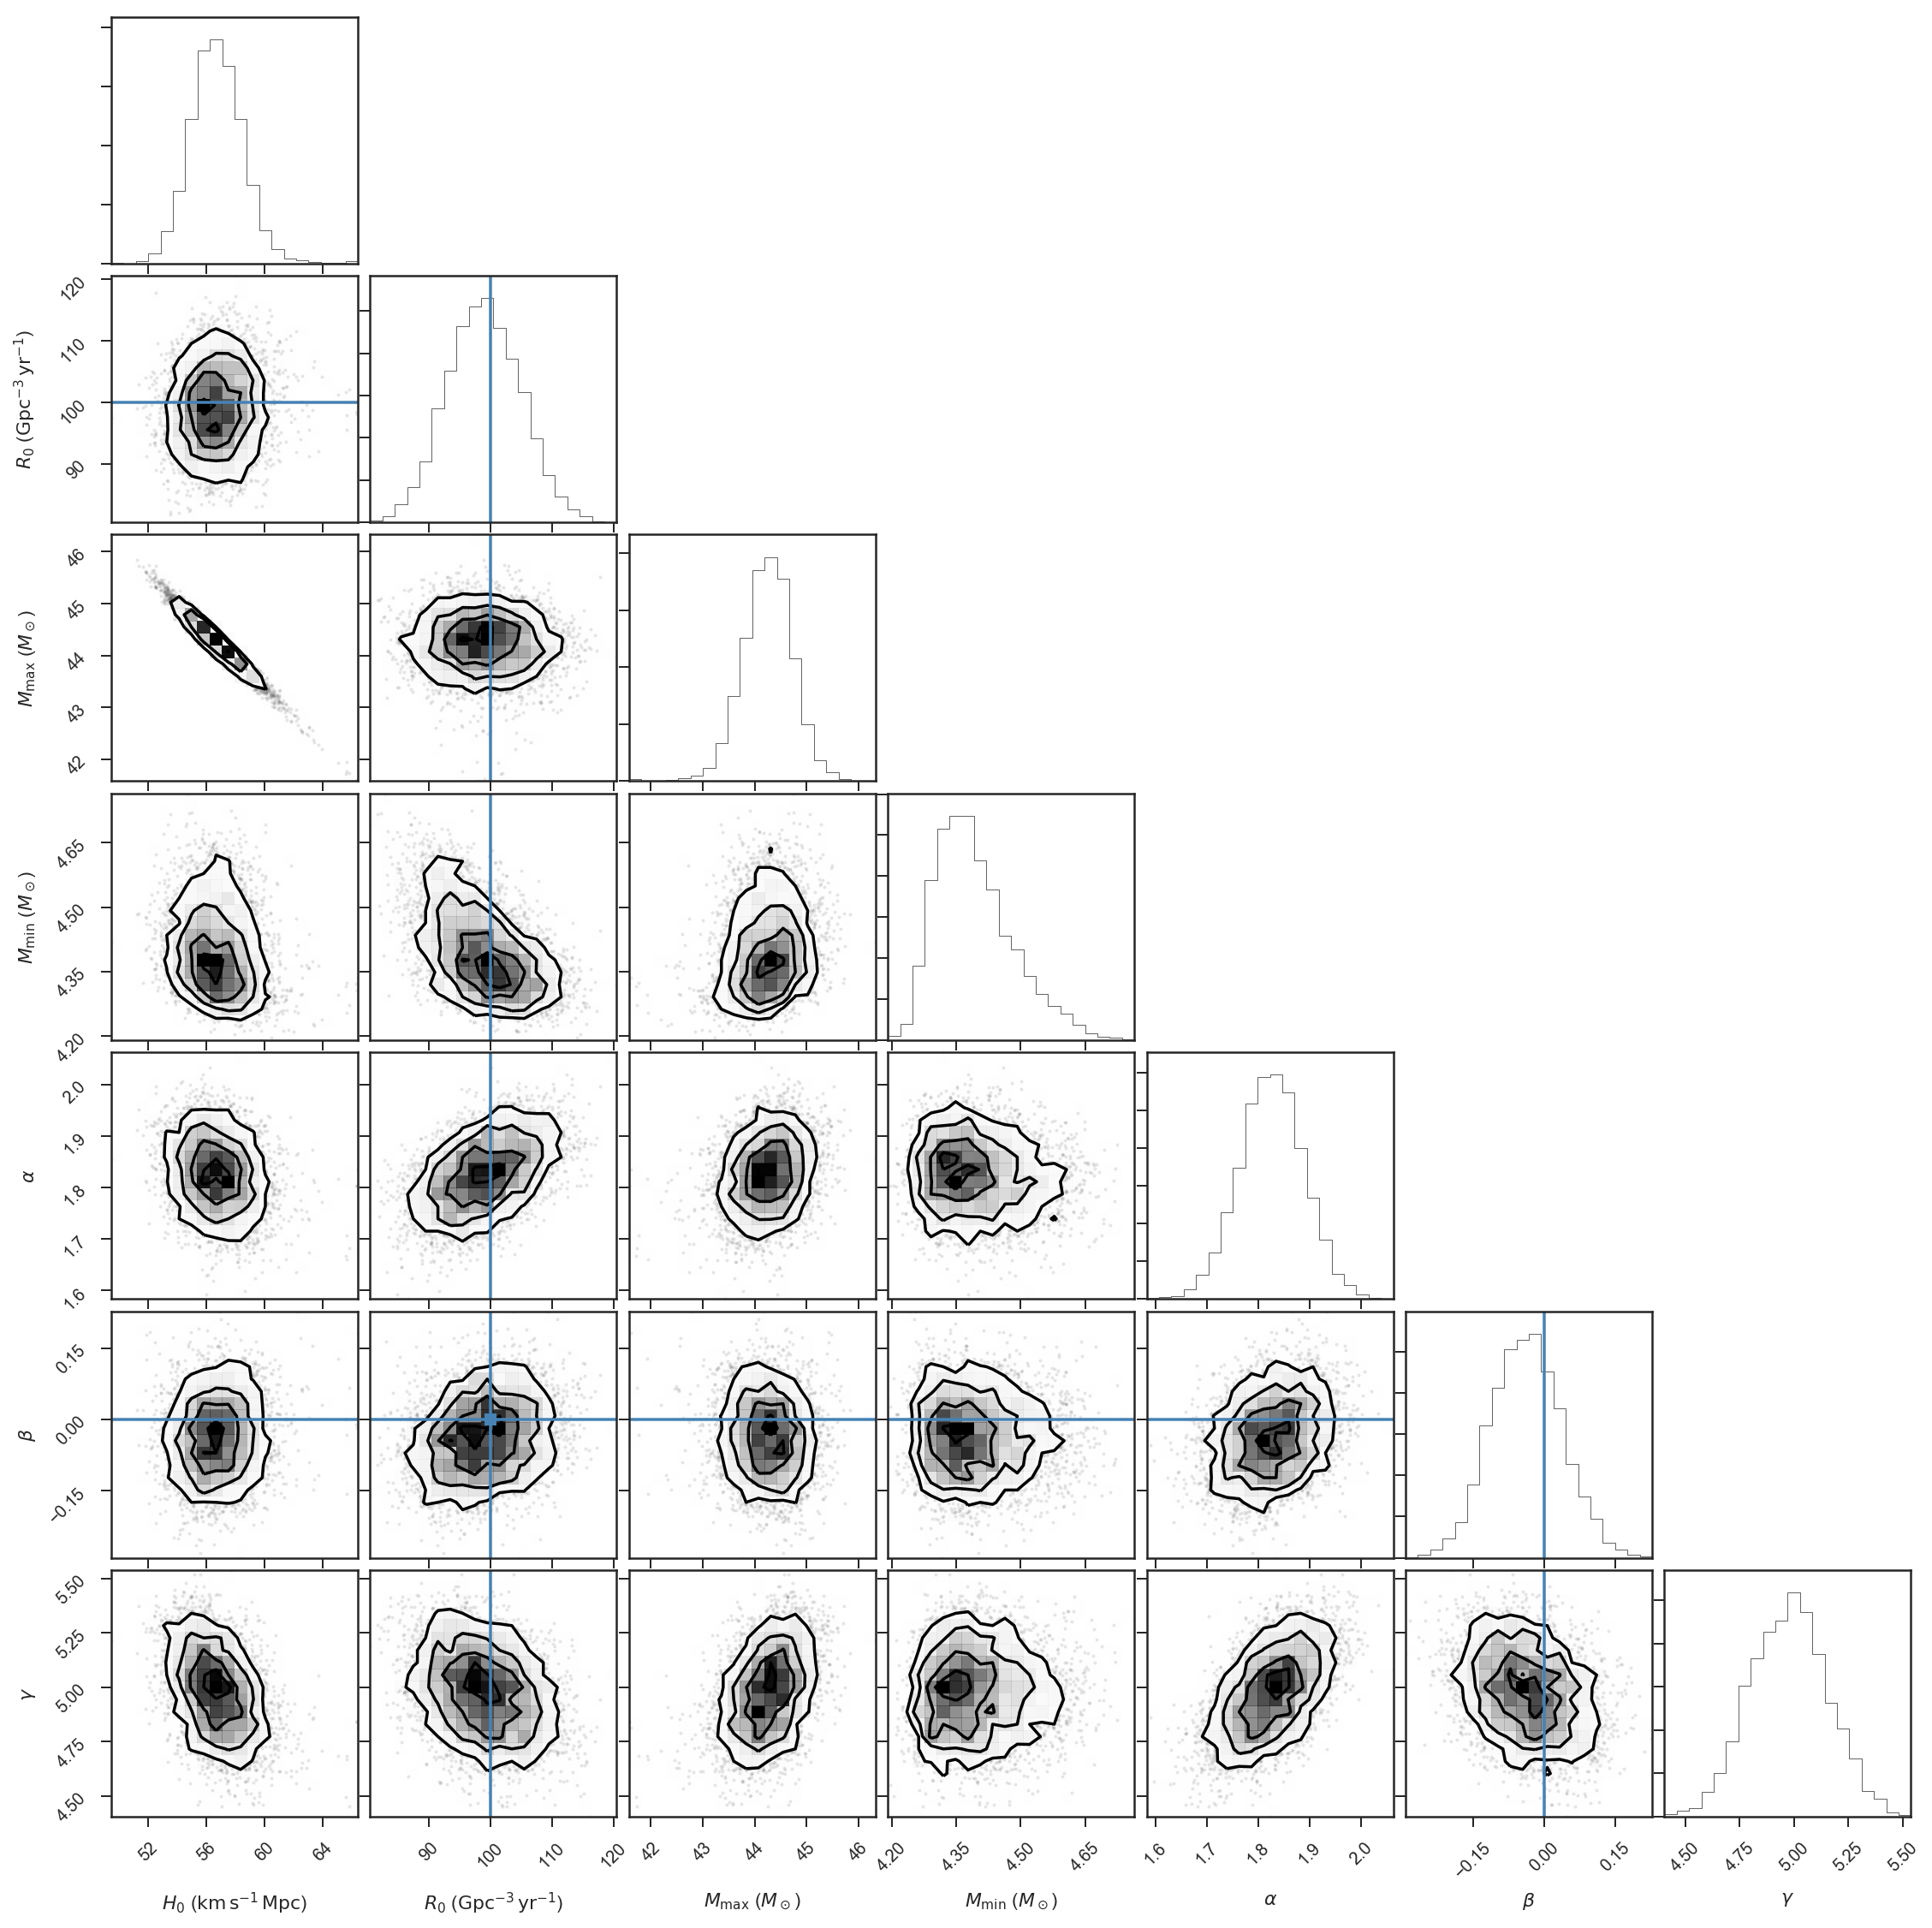

In [83]:
corner.corner(column_stack([chain_pop_5yr[nbest][n] for n in ['H0', 'R0', 'MMax', 'MMin', 'alpha', 'beta', 'gamma']]), 
              labels=[r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}$)', 
                      r'$R_0$ ($\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$)', 
                      r'$M_\mathrm{max}$ ($M_\odot$)',
                      r'$M_\mathrm{min}$ ($M_\odot$)',
                      r'$\alpha$',
                      r'$\beta$',
                      r'$\gamma$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, 
                      100.0,
                      MMax,
                      MMin,
                      1,
                      0,
                      3]);

H0 = 56.7 + 1.8 - 1.6 km/s/Mpc (1-sigma) after one year
1-sigma interval is 1.7


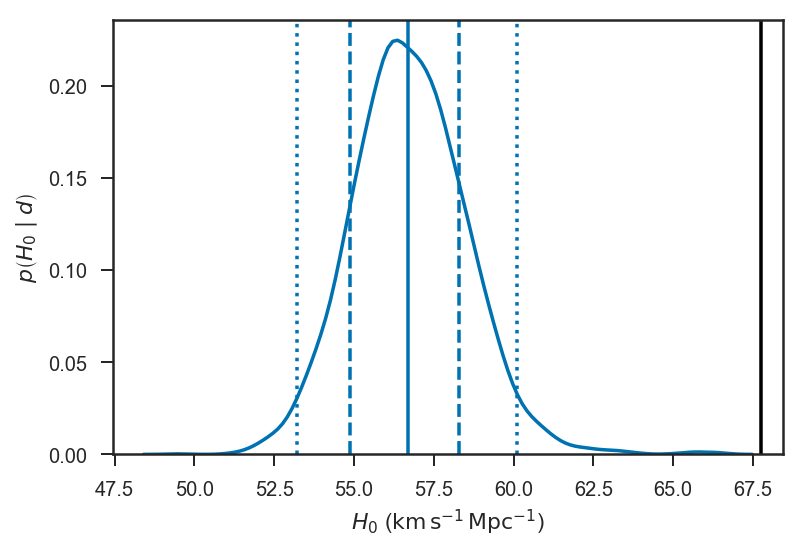

In [87]:
sns.kdeplot(chain_pop_5yr[nbest]['H0'])
xlabel(r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}^{-1}$)')
ylabel(r'$p\left( H_0 \mid d \right)$')
axvline(Planck15.H0.to(u.km/u.s/u.Mpc).value, color='k')

m = median(chain_pop_5yr[nbest]['H0'])
l, h = spd_interval(chain_pop_5yr[nbest]['H0'], 0.68)
ll, hh = spd_interval(chain_pop_5yr[nbest]['H0'], 0.95)

axvline(m)
axvline(l, ls='--')
axvline(h, ls='--')
axvline(ll, ls=':')
axvline(hh, ls=':')

dl = m-l
dh = h - m

print('H0 = {:.1f} + {:.1f} - {:.1f} km/s/Mpc (1-sigma) after one year'.format(m, dl, dh))
print('1-sigma interval is {:.1f}'.format((h-l)/2))

Text(0,0.5,'$m_1$ ($M_\\odot$)')

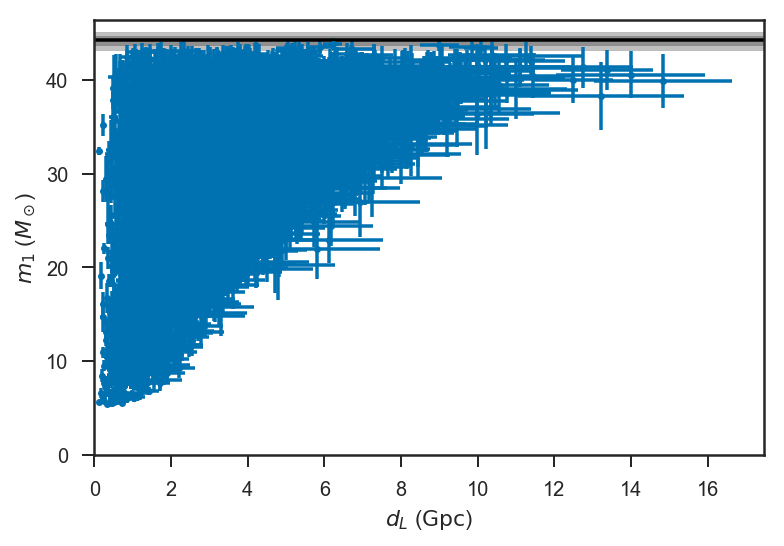

In [86]:
c = chain_pop_5yr[nbest]

m1 = mean(c['m1s_true'], axis=0)
sm1 = std(c['m1s_true'], axis=0)

dl = mean(c['dls_true'], axis=0)
sdl = std(c['dls_true'], axis=0)

errorbar(dl, m1, xerr=sdl, yerr=sm1, fmt='.')

gca().set_xlim(left=0)
gca().set_ylim(bottom=0)

xl, xh = gca().get_xlim()

plot([xl,xh], median(c['MMax'])*ones(2), color='k', ls='-')
fill_between([xl,xh], percentile(c['MMax'], 84), percentile(c['MMax'], 16), alpha=0.25, color='k')
fill_between([xl,xh], percentile(c['MMax'], 97.5), percentile(c['MMax'], 2.5), alpha=0.25, color='k')

xlabel(r'$d_L$ ($\mathrm{Gpc}$)')
ylabel(r'$m_1$ ($M_\odot$)')

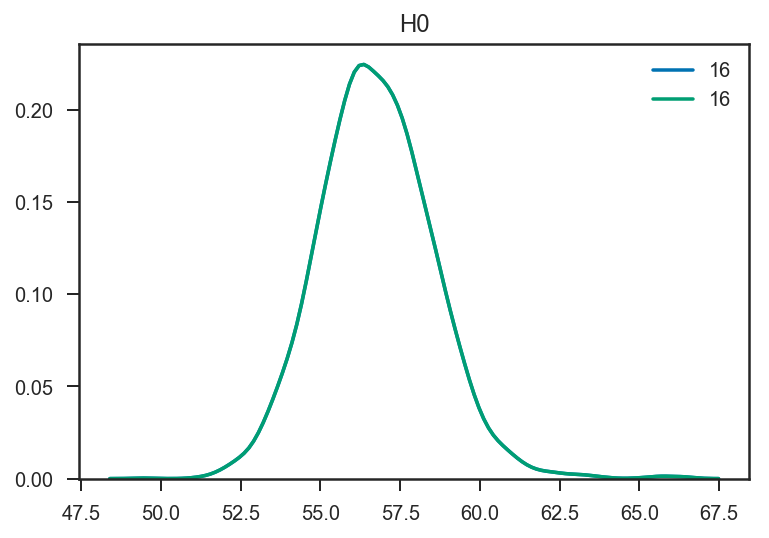

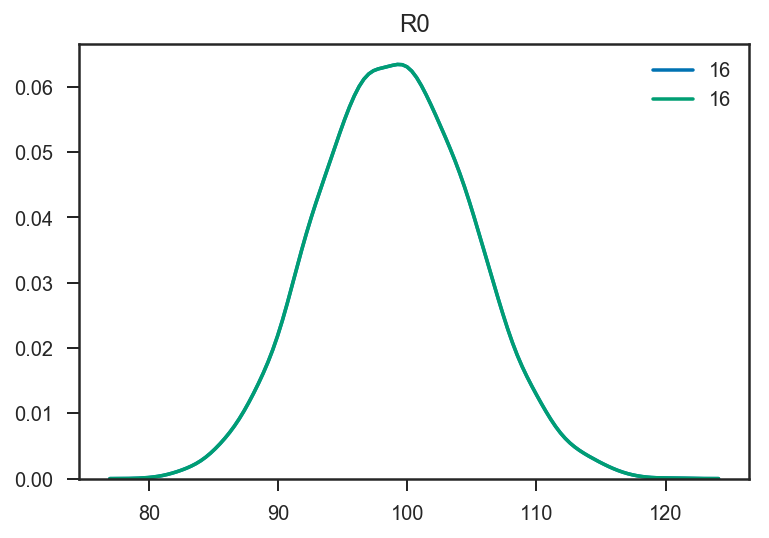

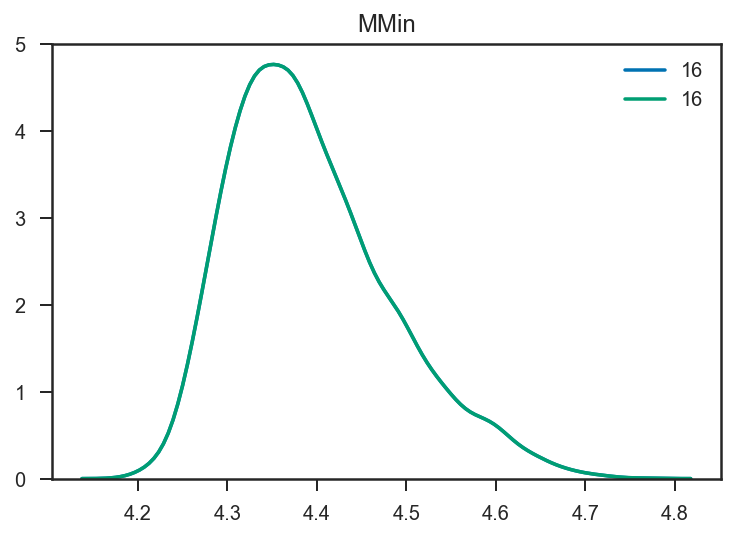

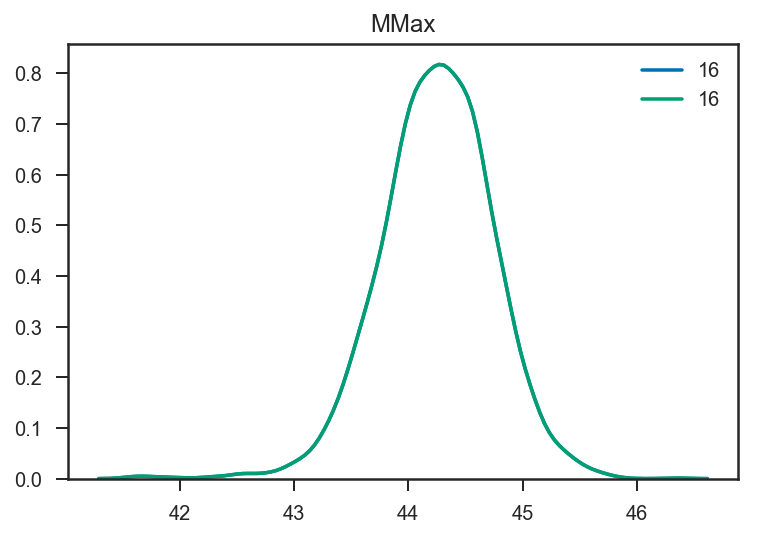

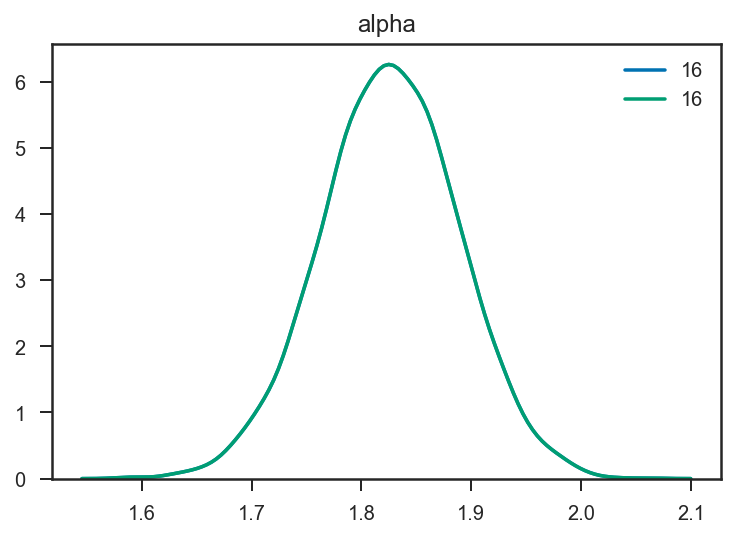

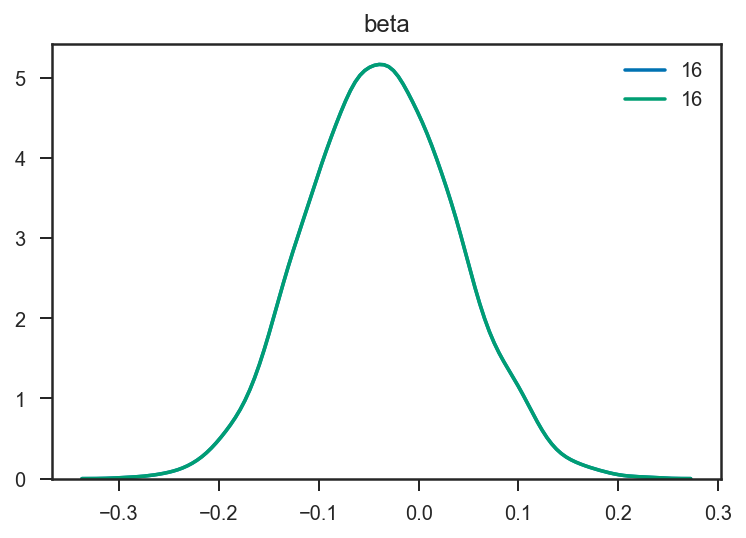

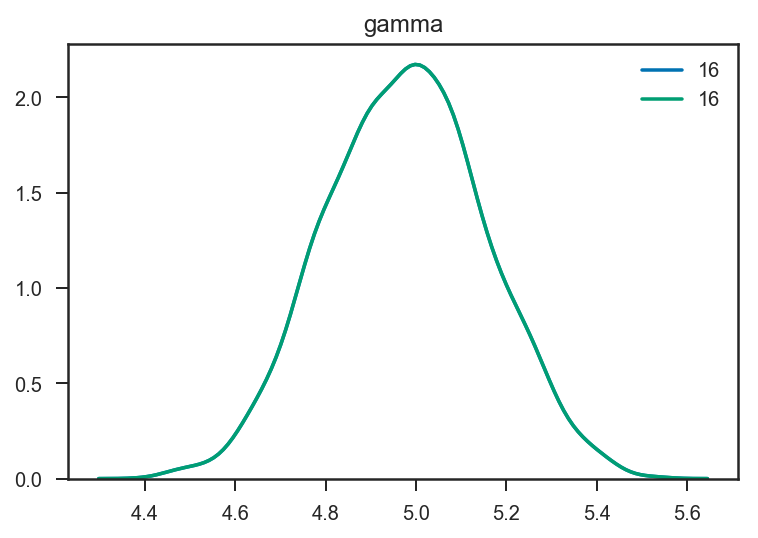

In [85]:
for n in ['H0', 'R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma']:
    figure()
    title(n)
    for nn in [nbest, n2best]:
        c = chain_pop_5yr[nn][n]
        sns.kdeplot(c, label=str(nn))
    legend(loc='best')

In [7]:
model = pystan.StanModel(file='PISNLineCosmographyGaussian.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ef7e54759d8473f2e3496d0815442508 NOW.


In [8]:
pts = stack((chain_1yr['m1s'], chain_1yr['m2s'], chain_1yr['dLs']), axis=2)
mu = mean(pts, axis=1)
sigma = array([cov(pts[i,:,:], rowvar=False) for i in range(pts.shape[0])])

In [9]:
def init(chain_id=0):
    H0 = 70 + 5*randn()
    R0 = 100 + 10*randn()
    
    c = cosmo.FlatLambdaCDM(H0, Planck15.Om0)
    
    i = randint(pts.shape[1])
    
    p = pts[:,i,:]
    
    z = array([cosmo.z_at_value(c.luminosity_distance, p[i,2]*u.Gpc) for i in range(p.shape[0])])
    
    m1 = p[:,0]/(1+z)
    m2 = p[:,1]/(1+z)
    
    MMin = np.min(m2)-0.5*rand()
    MMax = np.max(m1)+0.5*rand()
    
    m2f = (m2-MMin)/(m1-MMin)
    
    a = alpha + 0.2*randn()
    b = beta + 0.2*randn()
    g = 3 + 0.2*randn()
    
    return {
        'H0': H0,
        'R0': R0,
        
        'alpha': a,
        'beta': b,
        'gamma': g,
        
        'MMin': MMin,
        'MMax': MMax,
        
        'm1_true': m1,
        'm2_frac': m2f,
        'dl_true': p[:,2]
    }

In [10]:
ndet = 1024

d = {
    'nobs': mu.shape[0],
    'ndet': ndet,
    
    'ninterp': 100,
    
    'mu_m1obs_m2obs_dL': mu,
    'Sigma_m1obs_m2obs_dL': sigma,
    
    'm1obs_det': m1s_det[:ndet],
    'm2obs_det': m2s_det[:ndet],
    'dlobs_det': dls_det[:ndet],
    'wts_det': wts_det[:ndet],
    
    'Tobs': duty_cycle,
    
    'dLMax': dLmax,
    'Ngen': int(round(N_gen*ndet/float(m1s_det.shape[0]))),
    
    'smooth_low': 0.6,
    'smooth_high': 0.4
}

In [11]:
f = model.sampling(data=d, iter=200, init=init)

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [12]:
f

Inference for Stan model: anon_model_ef7e54759d8473f2e3496d0815442508.
4 chains, each with iter=200; warmup=100; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=400.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0            64.69    0.88   6.98  50.95  60.61  64.53  69.64  77.26   63.0   1.04
R0           260.69    1.56  29.27 208.12 238.48 259.97 278.98 320.49  353.0    1.0
alpha          1.45  7.9e-3   0.13    1.2   1.35   1.45   1.53   1.72  268.0    1.0
beta           -0.1  9.0e-3   0.15  -0.39  -0.19  -0.11-7.2e-3   0.23  273.0   1.01
gamma          1.61    0.02   0.31   0.96    1.4   1.63   1.82   2.15  400.0    1.0
MMin           4.32  5.5e-3   0.11   4.07   4.24   4.33    4.4    4.5  400.0   1.01
MMax          42.67    0.14   1.18   40.6  41.82  42.64  43.42  45.06   69.0   1.04
m1_true[0]    18.95    0.17   2.42  14.73   17.2  18.71  20.77  24.14  196.0    1.0
m1_true[1]    26.18    0.26   3.39  20.28  23.73  26.01  28

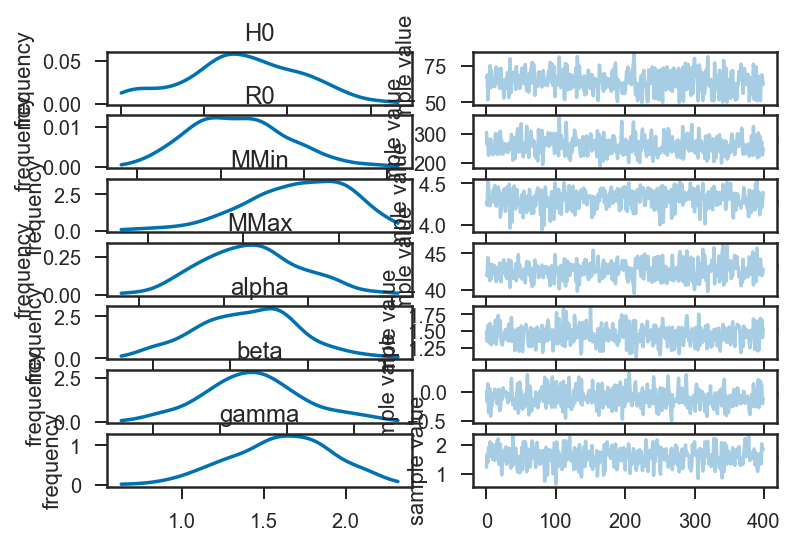

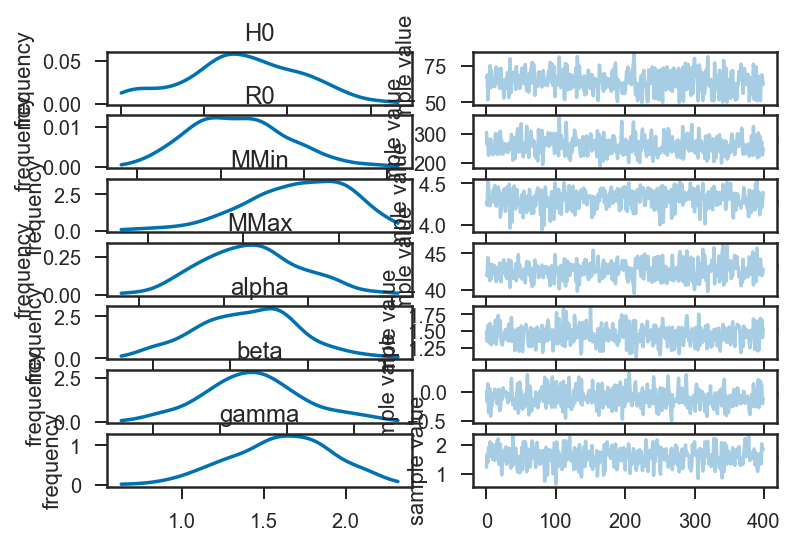

In [13]:
f.plot(['H0', 'R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma'])

In [14]:
c = f.extract(permuted=True)

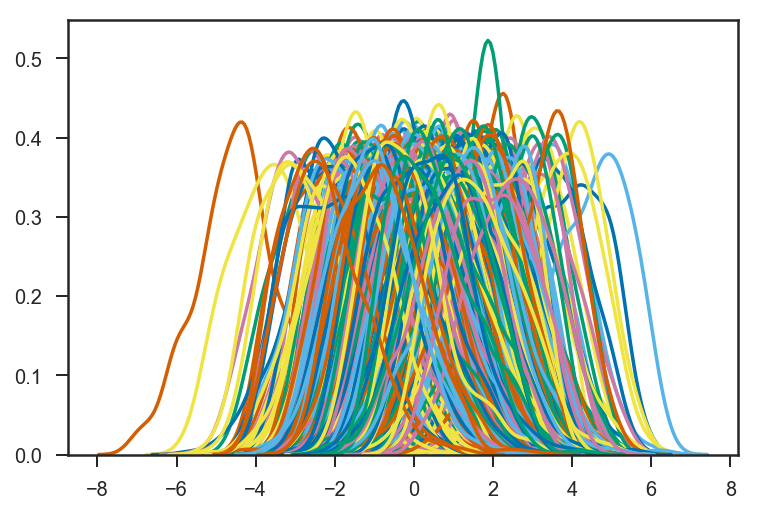

In [16]:
for i in range(c['m1_true'].shape[1]):
    sns.kdeplot((c['m1_true'][:,i] - m1s[i])/std(c['m1_true'][:,i]))

In [19]:
p = []
for i in range(c['m1_true'].shape[1]):
    p.append(count_nonzero(m1s[i] < c['m1_true'][:,i])/400.0)
p = array(p)

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


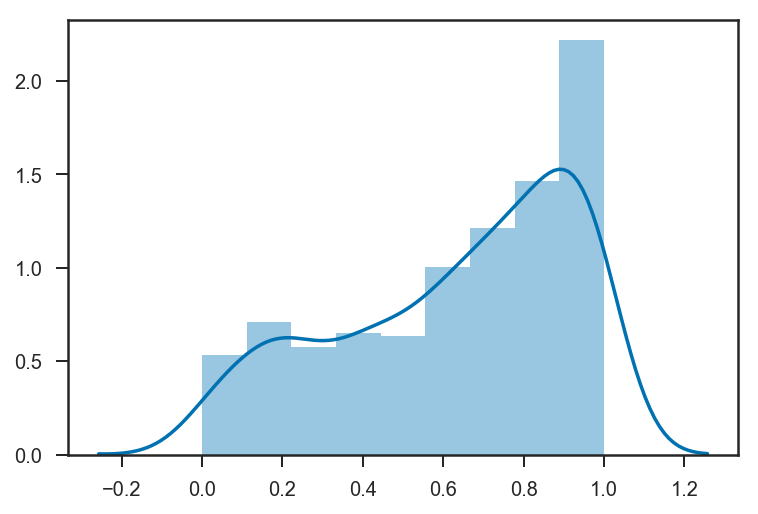

In [20]:
sns.distplot(p)

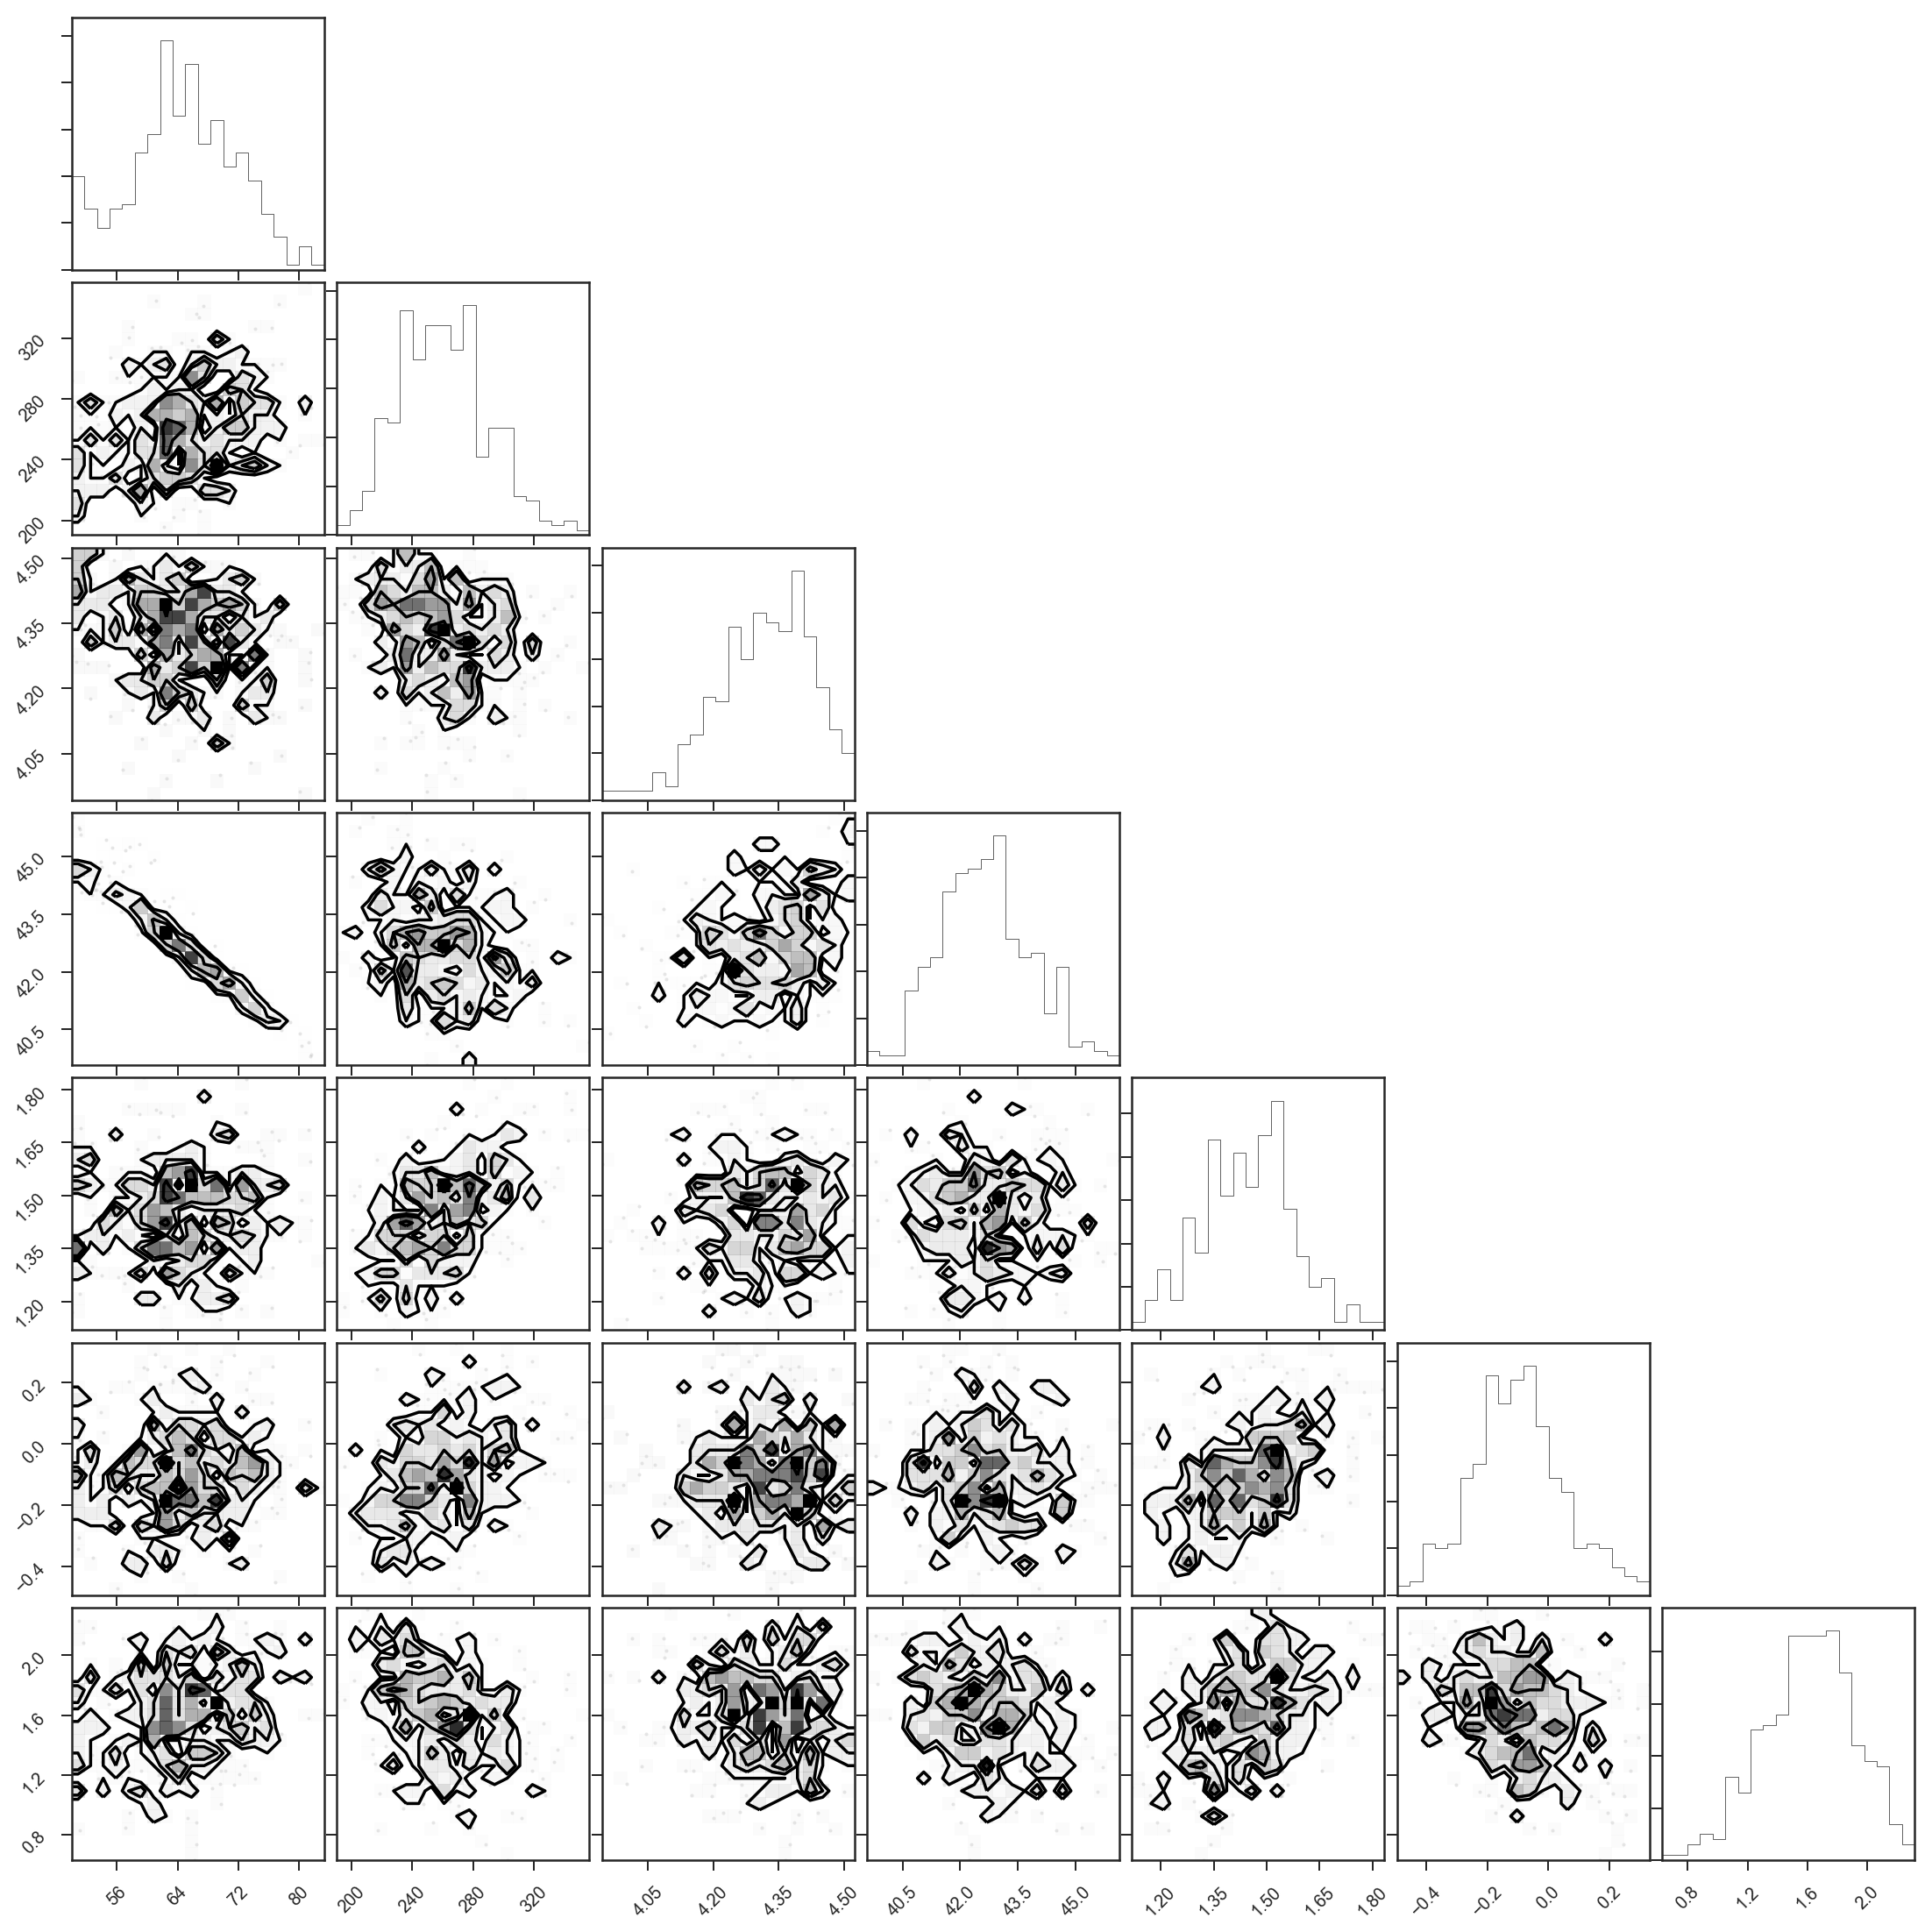

In [22]:
corner.corner(column_stack([c[k] for k in ['H0', 'R0', 'MMin', 'MMax', 'alpha', 'beta', 'gamma']]));

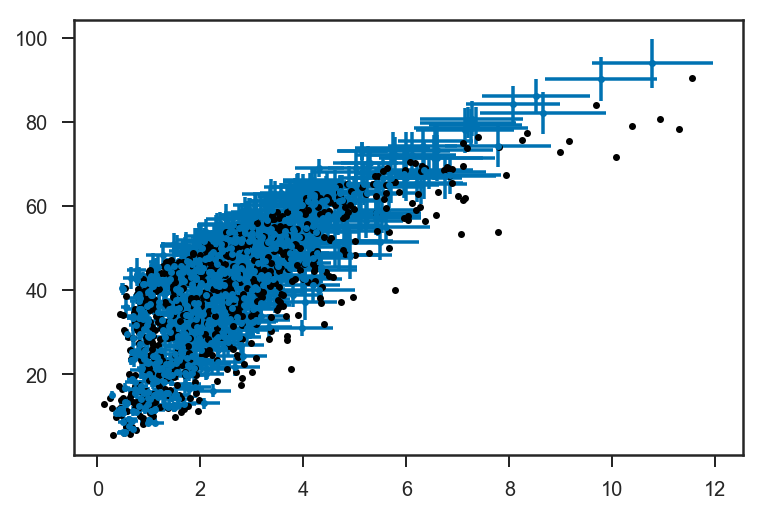

In [25]:
mo = c['m1_true']*(1+c['z_true'])
d = c['dl_true']

errorbar(mean(d, axis=0), mean(mo, axis=0), xerr=std(d, axis=0), yerr=std(mo, axis=0), fmt='.')
plot(dls[:N_1yr], m1s[:N_1yr]*(1+zs[:N_1yr]), '.k')

In [56]:
cng = {}

In [57]:
mng = pystan.StanModel(file='PISNLineCosmographyDeltaLikelihood.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ab686191f170b0951eb7e65be614b49 NOW.


In [105]:
N = int(round(N_1yr/10.0))

m1obs = m1s[:N]*(1+zs[:N])
m2obs = m2s[:N]*(1+zs[:N])
dlobs = dls[:N]

ndet = 8192
nds = slice(0, ndet)
ndet_key = ndet

zs_det = array([cosmo.z_at_value(Planck15.luminosity_distance, d*u.Gpc) for d in dls_det[nds]])

m1d = m1s_det[nds]/(1+zs_det)
m2d = m2s_det[nds]/(1+zs_det)

sl = np.max(np.diff(np.sort(m2d[(m2d > 3) & (m2d < 10)])))
sh = np.max(np.diff(np.sort(m1d[(m1d>30) & (m1d < 100)])))

print('smooth-low = {:.1f}, smooth-high = {:.1f}'.format(sl, sh))

dng = {
    'nobs': m1obs.shape[0],
    'ndet': ndet,
    
    'ninterp': 100,
    
    'm1obs': m1obs,
    'm2obs': m2obs,
    'dlobs': dlobs,
    
    'm1obs_det': m1s_det[nds],
    'm2obs_det': m2s_det[nds],
    'dlobs_det': dls_det[nds],
    'wts_det': wts_det[nds],
    
    'Tobs': duty_cycle,
    
    'dLMax': dLmax,
    'Ngen': int(round(N_gen*ndet/(m1s_det.shape[0]))),
    
    'smooth_low': sl,
    'smooth_high': sh
}

smooth-low = 0.6, smooth-high = 0.1


In [107]:
def initng(chain_id=0):
    H0 = 70+5*randn()
    R0 = 100+10*randn()
    
    a = alpha + 0.5*randn()
    b = beta + 0.5*randn()
    g = 3 + 0.5*randn()
        
    dMMax = rand()
    
    return {
        'H0': H0,
        'R0': R0,
        'alpha': a,
        'beta': b,
        'gamma': g,
        'dMMax': dMMax
    }

In [108]:
fng = mng.sampling(data=dng, iter=2000, init=initng)

In [111]:
fng

Inference for Stan model: anon_model_5ab686191f170b0951eb7e65be614b49.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0             70.77    0.11   5.41  58.14  67.46   71.3  74.17  80.88 2525.0    1.0
R0              12.1    0.06   3.18   6.98   9.75  11.78  14.11  19.13 2597.0    1.0
alpha          -0.16  7.5e-3   0.39  -0.94  -0.42  -0.16    0.1   0.61 2743.0    1.0
beta           -0.17  6.6e-3   0.39  -0.91  -0.43  -0.19   0.08   0.64 3478.0    1.0
gamma           1.85    0.02    0.8   0.35    1.3   1.84   2.38   3.47 2127.0    1.0
dMMax           0.19  2.9e-3   0.18 5.5e-3   0.05   0.13   0.26   0.67 4000.0    1.0
dH              4.26  7.3e-3   0.34   3.71   4.04    4.2   4.44   5.16 2235.0    1.0
Nex            63.37    0.13   7.92  48.86  57.79  62.97   68.5   80.0 4000.0    1.0
sigma_log_Nex   0.06  1.1e-4 6.9e-3   0.05   0

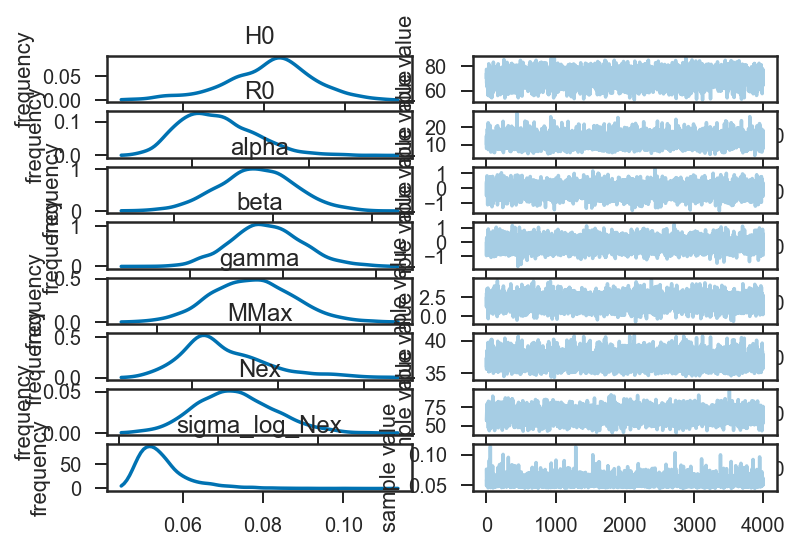

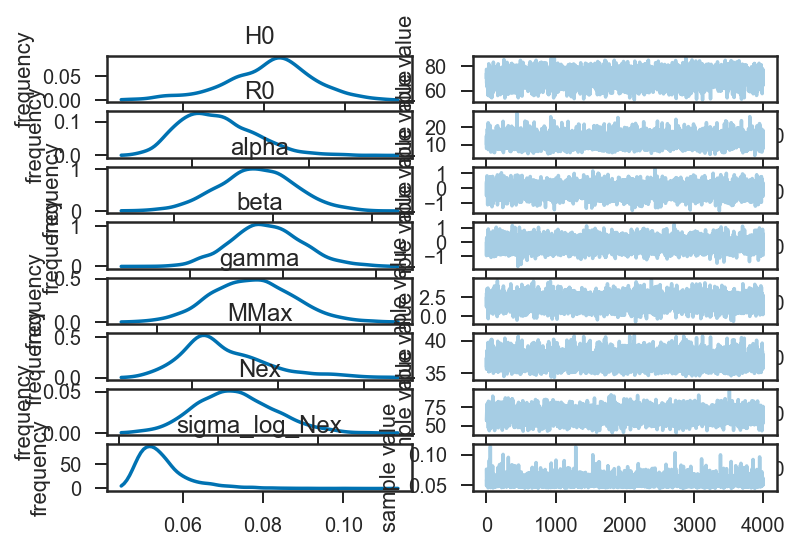

In [112]:
fng.plot(['H0', 'R0', 'alpha', 'beta', 'gamma', 'MMax', 'Nex', 'sigma_log_Nex'])

In [113]:
cng[ndet_key] = fng.extract(permuted=True)

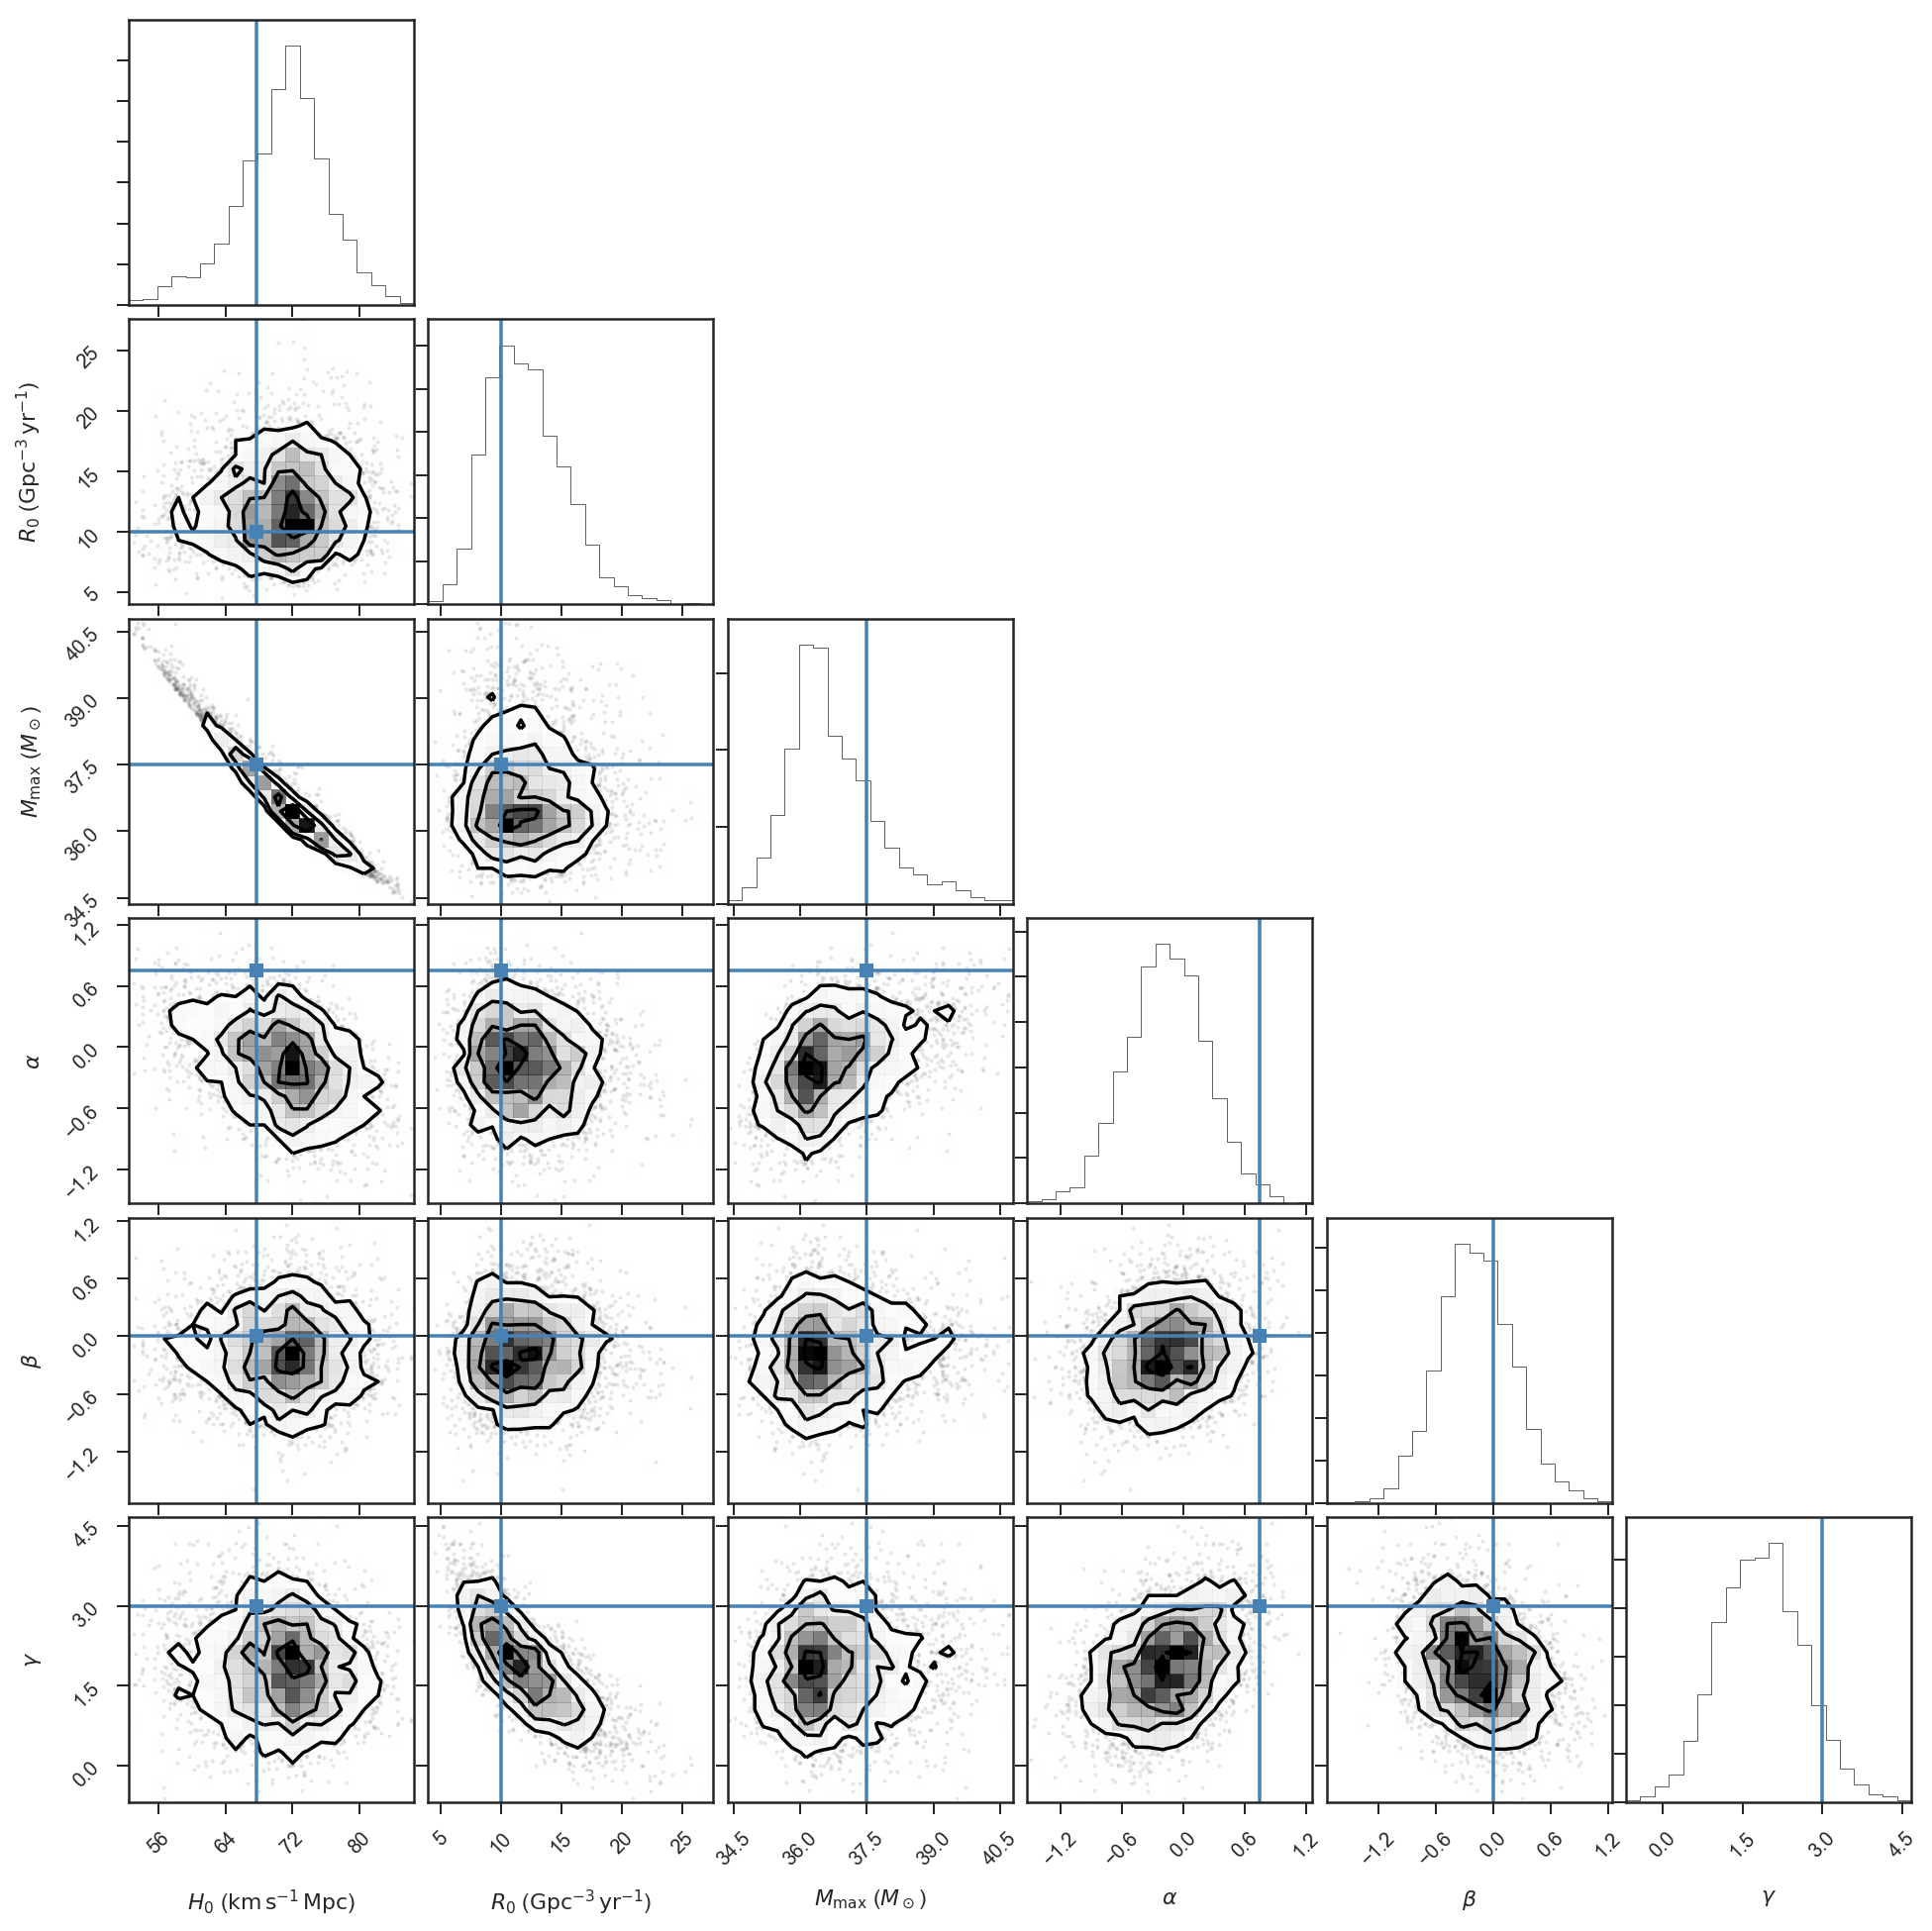

In [114]:
corner.corner(column_stack([cng[ndet_key][n] for n in ['H0', 'R0', 'MMax', 'alpha', 'beta', 'gamma']]), 
              labels=[r'$H_0$ ($\mathrm{km} \, \mathrm{s}^{-1} \, \mathrm{Mpc}$)', 
                      r'$R_0$ ($\mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}$)', 
                      r'$M_\mathrm{max}$ ($M_\odot$)',
                      r'$\alpha$',
                      r'$\beta$',
                      r'$\gamma$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, 
                      10.0,
                      MMax,
                      alpha,
                      beta,
                      3]);

/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/wfarr/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


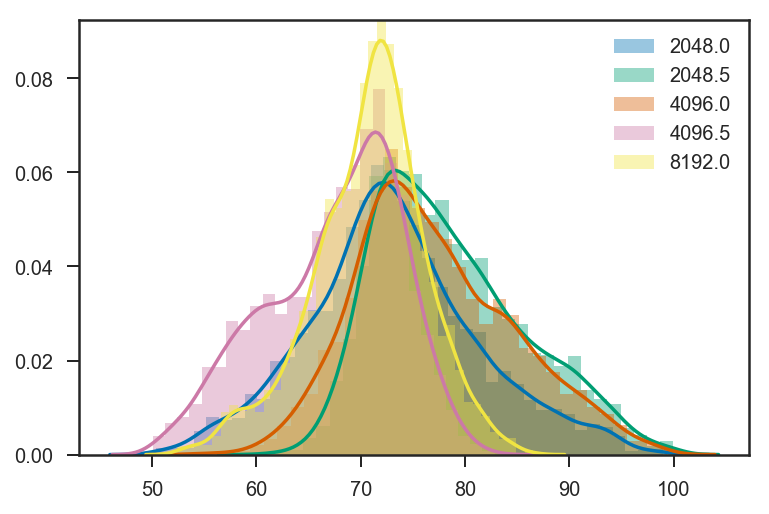

In [115]:
for k in sort(cng.keys()):
    sns.distplot(cng[k]['H0'], label=str(k))
legend(loc='best')